### This notebook looks at the communicability within and across ntwx with and without SC lesions 

#### The code for communicability, navigation, shortest path are courtesy of Caio Seguin and the Brain Connectivity Toolbox. 
#### They were originally written in Matlab and translated to python by Chat-GPT. 
#### All these functions exist in a script called `communicability_functions.py`
#### See this link for the orginal Matlab versions of the functions (the functions are in the `fcn` folder): https://github.com/brain-networks/local_scfc/tree/main

##### 'structurally isolate' means virtual lesions that make the regions of the a given network (eg: DMN) only have connections to itself.   
##### Essentially, you set the conncetions of the DMN regions/parcels with other ntwx to 0 in the SC mtx.  

##### All of the above will be done as an average for 200 subjects.
##### This NB uses a resolution of 200 Schaefer parcellations.  

In [1]:
# Importage
import warnings
warnings.filterwarnings('ignore')

# os stuff
import os
import sys

import nibabel as nib
from nilearn.plotting import plot_surf, plot_surf_stat_map, plot_roi, plot_anat, plot_surf_roi
from nilearn.image import index_img

import seaborn as sns

# whobpyt stuff
import whobpyt
from whobpyt.data.dataload import dataloader
# from whobpyt.models.jansen_rit import RNNJANSEN
from whobpyt.models.wong_wang import RNNRWW
from whobpyt.datatypes.modelparameters import ParamsModel
from whobpyt.optimization.modelfitting import Model_fitting

# array and pd stuff
import numpy as np
import pandas as pd

# viz stuff
import matplotlib.pyplot as plt

In [2]:
import networkx as nx

In [3]:
import seaborn as sns
import scipy.stats as stats

In [4]:
from collections import Counter

In [5]:
import pickle

In [6]:
from communicability_functions import communicability_wei, distance_wei_floyd, retrieve_shortest_path

In [7]:
parcs = np.arange(0,200,1)

mask = np.tril_indices(len(parcs), -1)

# Labels
_label_file =  '/external/rprshnas01/kcni/hharita/Code/whobpyt/scratch/Schaefer200_7_Ntwx_labels.txt'

f = open(_label_file, "r")
q = f.read()
q = q.rsplit('\n')
# del q[-32:]
labels = q.copy()
labels = np.array(labels)
labels = labels[parcs]


In [8]:
import re

In [9]:
folder_one_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II'
folder_two_path = SCs_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Improved_WWD_HCP_model_runs/All_Subs_SC_Wts/Davide_HCP_Data_Matrix'

# Get the list of files in each folder
folder_one_files = os.listdir(folder_one_path)
folder_two_files = os.listdir(folder_two_path)

# Extract the numbers from the filenames in folder_one
folder_one_numbers = []
for file in folder_one_files:
    match = re.search(r'\d+', file)
    if match:
        folder_one_numbers.append(int(match.group()))

# Extract the numbers from the filenames in folder_two
folder_two_numbers = []
for file in folder_two_files:
    match = re.search(r'\d+', file)
    if match:
        folder_two_numbers.append(int(match.group()))

# Find the common numbers between the two folders
common_numbers = list(set(folder_one_numbers) & set(folder_two_numbers))

sub_list = common_numbers.copy()

sub_list.sort()

sub_list = sub_list[0:200]

In [10]:
Wts_Path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Improved_WWD_HCP_model_runs/All_Subs_SC_Wts/Davide_HCP_Data_Matrix'

In [11]:
def load_wts(sub_id):

    _df = pd.read_csv(Wts_Path + '/{0}/{0}_new_atlas_Yeo.nii.csv'.format(sub_id), delimiter=' ',header=None)
    df_trimmed = _df.iloc[:-31, :-31]
    np_array = df_trimmed.values
    sc_mtx = np_array + np_array.T # --> Symmetric

    pre_laplachian_HCP_SC = sc_mtx.copy()

    SC = pre_laplachian_HCP_SC.copy()
    sc = np.log1p(SC) / np.linalg.norm(np.log1p(SC))
    
    return pre_laplachian_HCP_SC

In [12]:
%%time
all_subs_pre_lap_SC = []

for i in range(len(sub_list)):
    pre_lap_SC = load_wts(sub_list[i])
    all_subs_pre_lap_SC.append(pre_lap_SC)

CPU times: user 6.97 s, sys: 136 ms, total: 7.11 s
Wall time: 1min 9s


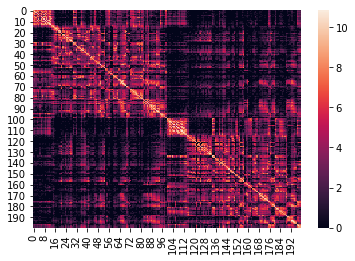

In [13]:
sns.heatmap(np.log1p(all_subs_pre_lap_SC[0]))

In [14]:
pconn_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II/'

In [15]:
def emp_fc(sub_id):
    pconn1LR = pconn_path + '{0}_rfMRI_REST1_RL_Schaefer200_cifti_parcellated.ptseries.nii'.format(sub_id)
    pconn_img1LR = nib.load(pconn1LR)
    pconn_dat1LR = pconn_img1LR.get_data()
    pconn_dat1LR = pconn_dat1LR/1
    return pconn_dat1LR

In [16]:
%%time

all_subs_emp_fc = []
for i in range(len(sub_list)):
    ss_emp_fc = emp_fc(sub_list[i])
    all_subs_emp_fc.append(ss_emp_fc)

CPU times: user 1min, sys: 544 ms, total: 1min 1s
Wall time: 3min 15s


In [17]:
%%time
all_subs_emp_fc_mat = []
for i in range(200):
    all_subs_emp_fc_mat.append(np.corrcoef(all_subs_emp_fc[i].T))

CPU times: user 1.46 s, sys: 89.9 ms, total: 1.55 s
Wall time: 1.55 s


In [18]:
og_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/200_subjects_WhoBPyT_run'
lesion_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/Ntwx_Lesion_WhoBPyT_200_subs'

In [19]:
# Subj_164030_vis_lesion_cc_cut_fc_con_mat.txt
# Subj_164030_vis_lesion_fc_con_mat.txt

###  Takes 45 mins ... strap in!

In [20]:
%%time

all_subs_og_whobpyt = []

all_subs_vis_lesion = []
# all_subs_vis_lesion_cc_cut = []

all_subs_sommot_lesion = []
# all_subs_sommot_lesion_cc_cut = []

all_subs_dorsattn_lesion = []
# all_subs_dorsattn_lesion_cc_cut = []

all_subs_ventattn_lesion = []
# all_subs_ventattn_lesion_cc_cut = []

all_subs_limbic_lesion = []
# all_subs_limbic_lesion_cc_cut = []

all_subs_fpn_lesion = []
# all_subs_fpn_lesion_cc_cut = []

all_subs_dmn_lesion = []
# all_subs_dmn_lesion_cc_cut = []

for i in range(len(sub_list)):
    
    sub_id = sub_list[i]
    
    ss_og_whobpyt = np.loadtxt(og_whobpyt_path + '/{0}_whobypt_fc_mtx.txt'.format(sub_id))
    all_subs_og_whobpyt.append(ss_og_whobpyt)
    
    ss_vis_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_vis_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_vis_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_vis_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_vis_lesion.append(ss_vis_lesion)
#     all_subs_vis_lesion_cc_cut.append(ss_vis_lesion_cc_cut)
    

    ss_sommot_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_sommot_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_sommot_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_sommot_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_sommot_lesion.append(ss_sommot_lesion)
#     all_subs_sommot_lesion_cc_cut.append(ss_sommot_lesion_cc_cut)

    ss_dorsattn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dorsattn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_dorsattn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dorsattn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_dorsattn_lesion.append(ss_dorsattn_lesion)
#     all_subs_dorsattn_lesion_cc_cut.append(ss_dorsattn_lesion_cc_cut)
    

    ss_ventattn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_ventattn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_ventattn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_ventattn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_ventattn_lesion.append(ss_ventattn_lesion)
#     all_subs_ventattn_lesion_cc_cut.append(ss_ventattn_lesion_cc_cut)

    
    ss_limbic_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_limbic_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_limbic_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_limbic_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_limbic_lesion.append(ss_limbic_lesion)
#     all_subs_limbic_lesion_cc_cut.append(ss_limbic_lesion_cc_cut)

    
    ss_fpn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_fpn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_fpn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_fpn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_fpn_lesion.append(ss_fpn_lesion)
#     all_subs_fpn_lesion_cc_cut.append(ss_fpn_lesion_cc_cut)

    
    ss_dmn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dmn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_dmn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dmn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_dmn_lesion.append(ss_dmn_lesion)
#     all_subs_dmn_lesion_cc_cut.append(ss_dmn_lesion_cc_cut)

CPU times: user 1min 23s, sys: 2.39 s, total: 1min 26s
Wall time: 4min 43s


In [21]:
all_subs_lesion_ntwx = [all_subs_vis_lesion,all_subs_sommot_lesion,
                        all_subs_dorsattn_lesion,all_subs_ventattn_lesion,
                        all_subs_limbic_lesion,all_subs_fpn_lesion,
                        all_subs_dmn_lesion]

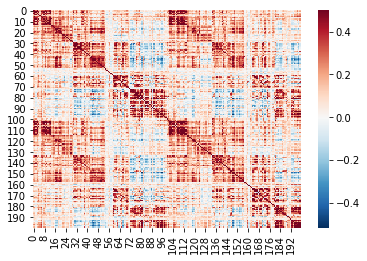

In [22]:
sns.heatmap(all_subs_emp_fc_mat[4], cmap='RdBu_r',center=0,vmax=0.5)

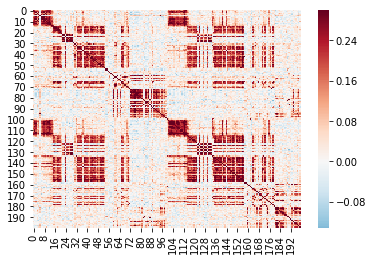

In [23]:
sns.heatmap(all_subs_og_whobpyt[4], cmap='RdBu_r',center=0,vmax=0.3)

In [24]:
corrs_list = []
for i in range(200):
    corrs_list.append(np.corrcoef(all_subs_emp_fc_mat[i][mask], all_subs_og_whobpyt[i][mask])[0][1])

In [25]:
# corrs_list

In [26]:
ntwx_labels_idxs = [
[0,14,100,115],
[14,30,115,134],
[30,43,134,147],
[43,54,147,158],
[54,60,158,164],
[60,73,164,181],
[73,100,181,200]]

In [27]:
Ntwx_labels = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

###  get the distance mtx

In [28]:
# from Davide's OHBM 2023 educational course google colab: 
# https://colab.research.google.com/drive/10irtJ_htqaicwL5r3DJOxu1vfQpAyYbK#scrollTo=AYDc8nuQAIjq

In [29]:
url = 'https://raw.githubusercontent.com/ThomasYeoLab/CBIG/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Centroid_coordinates/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv'
atlas = pd.read_csv(url)
label = atlas['ROI Name']

label_stripped = []

for xx in range(len(label)):
    label_stripped.append(label[xx].replace('7Networks_',''))


coords = np.array([atlas['R'], atlas['A'], atlas['S']]).T
conduction_velocity = 5 #in ms

distance = np.zeros((coords.shape[0], coords.shape[0]))

for roi1 in range(coords.shape[0]):
    for roi2 in range(coords.shape[0]):
        distance[roi1, roi2] = np.sqrt(np.sum((coords[roi1,:] - coords[roi2,:])**2, axis=0))
        distance[roi1, roi2] = np.sqrt(np.sum((coords[roi1,:] - coords[roi2,:])**2, axis=0))




--> `distance` is distance mtx

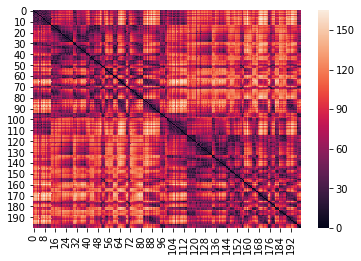

In [30]:
sns.heatmap(distance)

## Communicability

In [31]:
# intact sc

In [32]:
%%time
all_subs_communicability_sc = []

for i in range(200):
    sub_sc = all_subs_pre_lap_SC[i]
    communicability_sc = communicability_wei(sub_sc)
    all_subs_communicability_sc.append(communicability_sc)
    del communicability_sc

CPU times: user 6.74 s, sys: 71.8 ms, total: 6.81 s
Wall time: 7.09 s


In [176]:
# # NxN matrix dimensions

# for j in range(200):
#     matrix = all_subs_communicability_sc[i]
#     N = len(matrix)

#     print('Subject ', (j+1), '\n')
#     # Iterate through the matrix
#     for i in range(N):
#         for j in range(N):
#             # Check if the value is greater than 1
#             if matrix[i][j] > 1:
#                 print(f"Value at ({i}, {j}) is greater than 1: {matrix[i][j]}")

#             # Check if the value is less than 0
#             if matrix[i][j] < 0:
#                 print(f"Value at ({i}, {j}) is less than 0: {matrix[i][j]}")
#     print('-------------------------------------------------\n')

In [33]:
def structurally_isolate_func_ntwx(a,b,c,d, sc):
    
    modified_matrix = sc.copy()

    modified_matrix[a:b,0:a] = 0
    modified_matrix[a:b,b:c] = 0
    modified_matrix[a:b,d:200] = 0
    modified_matrix[c:d,0:a] = 0
    modified_matrix[c:d,b:c] = 0
    modified_matrix[c:d,d:200] = 0

    modified_matrix[0:a,a:b] = 0
    modified_matrix[b:c,a:b] = 0
    modified_matrix[d:200,a:b] = 0
    modified_matrix[0:a,c:d] = 0
    modified_matrix[b:c,c:d] = 0
    modified_matrix[d:200,c:d] = 0
    
#     modified_matrix = modified_matrix/np.linalg.norm(modified_matrix)
    
    return modified_matrix

In [34]:
# ntwx_labels_idxs = [
# [0,14,100,115],
# [14,30,115,134],
# [30,43,134,147],
# [43,54,147,158],
# [54,60,158,164],
# [60,73,164,181],
# [73,100,181,200]]

In [35]:
%%time
all_subs_sc_vis_lesion = []
all_subs_sc_smt_lesion = []
all_subs_sc_dan_lesion = []
all_subs_sc_van_lesion = []
all_subs_sc_lim_lesion = []
all_subs_sc_fpn_lesion = []
all_subs_sc_dmn_lesion = []

for i in range(200):
    sub_sc = all_subs_pre_lap_SC[i]
    
    vis_lesion_sc = structurally_isolate_func_ntwx(0,14,100,115, sub_sc)
    all_subs_sc_vis_lesion.append(vis_lesion_sc)
    del vis_lesion_sc
    
    smt_lesion_sc = structurally_isolate_func_ntwx(14,30,115,134, sub_sc)
    all_subs_sc_smt_lesion.append(smt_lesion_sc)
    del smt_lesion_sc
    
    dan_lesion_sc = structurally_isolate_func_ntwx(30,43,134,147, sub_sc)
    all_subs_sc_dan_lesion.append(dan_lesion_sc)
    del dan_lesion_sc
    
    van_lesion_sc = structurally_isolate_func_ntwx(43,54,147,158, sub_sc)
    all_subs_sc_van_lesion.append(van_lesion_sc)
    del van_lesion_sc
    
    lim_lesion_sc = structurally_isolate_func_ntwx(54,60,158,164, sub_sc)
    all_subs_sc_lim_lesion.append(lim_lesion_sc)
    del lim_lesion_sc
    
    fpn_lesion_sc = structurally_isolate_func_ntwx(60,73,164,181, sub_sc)
    all_subs_sc_fpn_lesion.append(fpn_lesion_sc)
    del fpn_lesion_sc
    
    dmn_lesion_sc = structurally_isolate_func_ntwx(73,100,181,200, sub_sc)
    all_subs_sc_dmn_lesion.append(dmn_lesion_sc)
    del dmn_lesion_sc

CPU times: user 88.2 ms, sys: 261 ms, total: 349 ms
Wall time: 348 ms


In [36]:
# lesion sc

In [37]:
%%time

all_subs_communicability_sc_vis_lesion = []
all_subs_communicability_sc_smt_lesion = []
all_subs_communicability_sc_dan_lesion = []
all_subs_communicability_sc_van_lesion = []
all_subs_communicability_sc_lim_lesion = []
all_subs_communicability_sc_fpn_lesion = []
all_subs_communicability_sc_dmn_lesion = []


for i in range(200):
    
    vis_communicability_sc = communicability_wei(all_subs_sc_vis_lesion[i])
    all_subs_communicability_sc_vis_lesion.append(vis_communicability_sc)
    del vis_communicability_sc

    
    smt_communicability_sc = communicability_wei(all_subs_sc_smt_lesion[i])
    all_subs_communicability_sc_smt_lesion.append(smt_communicability_sc)
    del smt_communicability_sc

    
    dan_communicability_sc = communicability_wei(all_subs_sc_dan_lesion[i])
    all_subs_communicability_sc_dan_lesion.append(dan_communicability_sc)
    del dan_communicability_sc

    
    van_communicability_sc = communicability_wei(all_subs_sc_van_lesion[i])
    all_subs_communicability_sc_van_lesion.append(van_communicability_sc)
    del van_communicability_sc

    
    lim_communicability_sc = communicability_wei(all_subs_sc_lim_lesion[i])
    all_subs_communicability_sc_lim_lesion.append(lim_communicability_sc)
    del lim_communicability_sc
    

    fpn_communicability_sc = communicability_wei(all_subs_sc_fpn_lesion[i])
    all_subs_communicability_sc_fpn_lesion.append(fpn_communicability_sc)
    del fpn_communicability_sc
    

    dmn_communicability_sc = communicability_wei(all_subs_sc_dmn_lesion[i])
    all_subs_communicability_sc_dmn_lesion.append(dmn_communicability_sc)
    del dmn_communicability_sc

CPU times: user 45.5 s, sys: 694 ms, total: 46.2 s
Wall time: 46.2 s


## WITHIN NETWORKS

In [38]:
def within_ntwx_SC(SC, a,b,c,d):
    
    ntwx_only_lh = SC[a:b, a:b]
    ntwx_only_rh = SC[c:d, c:d]

    ntwx_only_lhrh = SC[a:b, c:d]
    ntwx_only_rhlh = SC[c:d, a:b]
    
    mean_sc = (np.mean(ntwx_only_lh) + np.mean(ntwx_only_rh) + np.mean(ntwx_only_lhrh) + np.mean(ntwx_only_rhlh))/4
    
    return mean_sc

In [39]:
def within_ntwx_SC_communicability(SC):
    
    # lesion (DMN) whobpyt

    lesion_vis_sc_comm_all_subs = []
    lesion_smt_sc_comm_all_subs = []
    lesion_dan_sc_comm_all_subs = []
    lesion_van_sc_comm_all_subs = []
    lesion_lim_sc_comm_all_subs = []
    lesion_fpn_sc_comm_all_subs = []
    lesion_dmn_sc_comm_all_subs = []

    for i in range(200):

        ntwx_lesion_temp_vis = within_ntwx_SC(SC[i], 0, 14, 100, 115)
        lesion_vis_sc_comm_all_subs.append(ntwx_lesion_temp_vis)

        ntwx_lesion_temp_sommot = within_ntwx_SC(SC[i], 14, 30, 115, 134)
        lesion_smt_sc_comm_all_subs.append(ntwx_lesion_temp_sommot)

        ntwx_lesion_temp_dorsattn = within_ntwx_SC(SC[i], 30, 43, 134, 147)
        lesion_dan_sc_comm_all_subs.append(ntwx_lesion_temp_dorsattn)

        ntwx_lesion_temp_ventattn = within_ntwx_SC(SC[i], 43, 54, 147, 158)
        lesion_van_sc_comm_all_subs.append(ntwx_lesion_temp_ventattn)

        ntwx_lesion_temp_limbic = within_ntwx_SC(SC[i], 54, 60, 158, 164)
        lesion_lim_sc_comm_all_subs.append(ntwx_lesion_temp_limbic)

        ntwx_lesion_temp_fpn = within_ntwx_SC(SC[i], 60, 73, 164, 181)
        lesion_fpn_sc_comm_all_subs.append(ntwx_lesion_temp_fpn)

        ntwx_lesion_temp_dmn = within_ntwx_SC(SC[i], 73, 100, 181, 200)
        lesion_dmn_sc_comm_all_subs.append(ntwx_lesion_temp_dmn)


    lesion_vis_sc_comm_all_subs_mean = np.mean(lesion_vis_sc_comm_all_subs)
    lesion_smt_sc_comm_all_subs_mean = np.mean(lesion_smt_sc_comm_all_subs)
    lesion_dan_sc_comm_all_subs_mean = np.mean(lesion_dan_sc_comm_all_subs)
    lesion_van_sc_comm_all_subs_mean = np.mean(lesion_van_sc_comm_all_subs)
    lesion_lim_sc_comm_all_subs_mean = np.mean(lesion_lim_sc_comm_all_subs)
    lesion_fpn_sc_comm_all_subs_mean = np.mean(lesion_fpn_sc_comm_all_subs)
    lesion_dmn_sc_comm_all_subs_mean = np.mean(lesion_dmn_sc_comm_all_subs)


    ntwx_lesion_means_all_subs = [lesion_vis_sc_comm_all_subs,lesion_smt_sc_comm_all_subs,
                                  lesion_dan_sc_comm_all_subs,lesion_van_sc_comm_all_subs,
                                  lesion_lim_sc_comm_all_subs,lesion_fpn_sc_comm_all_subs,
                                  lesion_dmn_sc_comm_all_subs]
    
    ntwx_lesion_whobpyt_means = [lesion_vis_sc_comm_all_subs_mean,lesion_smt_sc_comm_all_subs_mean,
                                 lesion_dan_sc_comm_all_subs_mean,lesion_van_sc_comm_all_subs_mean,
                                 lesion_lim_sc_comm_all_subs_mean,lesion_fpn_sc_comm_all_subs_mean,
                                 lesion_dmn_sc_comm_all_subs_mean]
    
    return ntwx_lesion_whobpyt_means, ntwx_lesion_means_all_subs

In [40]:
intact_sc_comm_means, intact_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc)

vis_lesion_sc_comm_means, vis_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_vis_lesion)
smt_lesion_sc_comm_means, smt_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_smt_lesion)
dan_lesion_sc_comm_means, dan_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_dan_lesion)
van_lesion_sc_comm_means, van_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_van_lesion)
lim_lesion_sc_comm_means, lim_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_lim_lesion)
fpn_lesion_sc_comm_means, fpn_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_fpn_lesion)
dmn_lesion_sc_comm_means, dmn_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_dmn_lesion)

In [41]:
len(vis_lesion_sc_comm_all_subs[0])

200

In [139]:
all_sc_comm_means = [intact_sc_comm_means,
vis_lesion_sc_comm_means,
smt_lesion_sc_comm_means,
dan_lesion_sc_comm_means,
van_lesion_sc_comm_means,
lim_lesion_sc_comm_means,
fpn_lesion_sc_comm_means,
dmn_lesion_sc_comm_means]

In [140]:
type(all_sc_comm_means)

list

In [ ]:
with

In [126]:
# print(intact_sc_comm_means)
# print(vis_lesion_sc_comm_means)
# print(smt_lesion_sc_comm_means)
# print(dan_lesion_sc_comm_means)
# print(van_lesion_sc_comm_means)
# print(lim_lesion_sc_comm_means)
# print(fpn_lesion_sc_comm_means)
# print(dmn_lesion_sc_comm_means)

In [43]:
ntwx_labels = ['Vis','SomMot', 'DorsAttn', 'VentAttn', 'Limbic','FPN','DMN']

In [44]:
def stats_func(all_subs):
    _df = pd.DataFrame(all_subs,index=ntwx_labels)
    _df = _df.T
    

In [45]:
intact_sc_df = pd.DataFrame(intact_sc_comm_all_subs,index=ntwx_labels)
intact_sc_df = intact_sc_df.T

vis_lesion_df = pd.DataFrame(vis_lesion_sc_comm_all_subs,index=ntwx_labels)
vis_lesion_df = vis_lesion_df.T

smt_lesion_df = pd.DataFrame(smt_lesion_sc_comm_all_subs,index=ntwx_labels)
smt_lesion_df = smt_lesion_df.T

dan_lesion_df = pd.DataFrame(dan_lesion_sc_comm_all_subs,index=ntwx_labels)
dan_lesion_df = dan_lesion_df.T

van_lesion_df = pd.DataFrame(van_lesion_sc_comm_all_subs,index=ntwx_labels)
van_lesion_df = van_lesion_df.T


lim_lesion_df = pd.DataFrame(lim_lesion_sc_comm_all_subs,index=ntwx_labels)
lim_lesion_df = lim_lesion_df.T

fpn_lesion_df = pd.DataFrame(fpn_lesion_sc_comm_all_subs,index=ntwx_labels)
fpn_lesion_df = fpn_lesion_df.T

dmn_lesion_df = pd.DataFrame(dmn_lesion_sc_comm_all_subs,index=ntwx_labels)
dmn_lesion_df = dmn_lesion_df.T

#### vis lesion comm stats

In [46]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_ind(intact_sc_comm_all_subs[i], vis_lesion_sc_comm_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: -49.1934089750088
P-Value: 2.974034063349742e-171 

-------------------
Network =  SomMot
T-Statistic: -2.0417720331470828
P-Value: 0.04183297818789593 

-------------------
Network =  DorsAttn
T-Statistic: -14.787149798531658
P-Value: 9.606368850406695e-40 

-------------------
Network =  VentAttn
T-Statistic: -3.8858551641562658
P-Value: 0.00011941347099217674 

-------------------
Network =  Limbic
T-Statistic: -8.905587532135687
P-Value: 1.9129015321346188e-17 

-------------------
Network =  FPN
T-Statistic: -4.7668583492740195
P-Value: 2.6283929703230095e-06 

-------------------
Network =  DMN
T-Statistic: -16.45463127295428
P-Value: 8.812386317603187e-47 

-------------------


####  smt lesion comm stats

In [47]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_ind(intact_sc_comm_all_subs[i], smt_lesion_sc_comm_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: -1.9464559092677347
P-Value: 0.05230329376221893 

-------------------
Network =  SomMot
T-Statistic: -86.74413853168703
P-Value: 1.3046903932859369e-260 

-------------------
Network =  DorsAttn
T-Statistic: -36.37580179917309
P-Value: 1.273064230420407e-128 

-------------------
Network =  VentAttn
T-Statistic: -33.70313697899445
P-Value: 1.17384883503565e-118 

-------------------
Network =  Limbic
T-Statistic: -0.9058541473996038
P-Value: 0.3655611117237312 

-------------------
Network =  FPN
T-Statistic: -10.282188475047517
P-Value: 3.7777976075834195e-22 

-------------------
Network =  DMN
T-Statistic: -10.996134226479143
P-Value: 9.707743081697722e-25 

-------------------


#### dan lesion comm stats

In [48]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_ind(intact_sc_comm_all_subs[i], dan_lesion_sc_comm_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: -15.62713945640526
P-Value: 2.8791597088382385e-43 

-------------------
Network =  SomMot
T-Statistic: -28.308558927321158
P-Value: 2.2566859854785854e-97 

-------------------
Network =  DorsAttn
T-Statistic: -107.4339356791786
P-Value: 4.5872712028369537e-296 

-------------------
Network =  VentAttn
T-Statistic: -16.3240768029323
P-Value: 3.1764913467299344e-46 

-------------------
Network =  Limbic
T-Statistic: -2.7116934959791155
P-Value: 0.006984133351182065 

-------------------
Network =  FPN
T-Statistic: -19.203955465535653
P-Value: 1.2173480099866938e-58 

-------------------
Network =  DMN
T-Statistic: -17.180294983398348
P-Value: 6.858209866135028e-50 

-------------------


#### van lesion comm stats

In [49]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_ind(intact_sc_comm_all_subs[i], van_lesion_sc_comm_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: -2.331514544630397
P-Value: 0.02022462367283138 

-------------------
Network =  SomMot
T-Statistic: -30.253514267627555
P-Value: 3.188601679565319e-105 

-------------------
Network =  DorsAttn
T-Statistic: -14.476401964672723
P-Value: 1.8725163574200252e-38 

-------------------
Network =  VentAttn
T-Statistic: -97.92545399950282
P-Value: 1.2481116228996982e-280 

-------------------
Network =  Limbic
T-Statistic: -2.304565014022141
P-Value: 0.021704992500834585 

-------------------
Network =  FPN
T-Statistic: -16.21406456028586
P-Value: 9.343854529456148e-46 

-------------------
Network =  DMN
T-Statistic: -21.59253493371124
P-Value: 5.266878576447842e-69 

-------------------


#### lim lesion comm stats

In [50]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_ind(intact_sc_comm_all_subs[i], lim_lesion_sc_comm_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: -6.279134654319304
P-Value: 8.919667637786603e-10 

-------------------
Network =  SomMot
T-Statistic: -0.9200385952466925
P-Value: 0.35810987875426215 

-------------------
Network =  DorsAttn
T-Statistic: -1.633153311500093
P-Value: 0.1032275611478691 

-------------------
Network =  VentAttn
T-Statistic: -2.5785340137376456
P-Value: 0.010280436702513064 

-------------------
Network =  Limbic
T-Statistic: -73.7417843092594
P-Value: 3.4592737633683626e-234 

-------------------
Network =  FPN
T-Statistic: -5.591791898412138
P-Value: 4.182168089924933e-08 

-------------------
Network =  DMN
T-Statistic: -10.715798542870733
P-Value: 1.0358621685774945e-23 

-------------------


#### fpn lesion comm stats

In [51]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_ind(intact_sc_comm_all_subs[i], fpn_lesion_sc_comm_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: -6.525686815622404
P-Value: 2.0625206055320602e-10 

-------------------
Network =  SomMot
T-Statistic: -11.71125927755468
P-Value: 2.0127327722761286e-27 

-------------------
Network =  DorsAttn
T-Statistic: -25.5904147295151
P-Value: 4.25000473583081e-86 

-------------------
Network =  VentAttn
T-Statistic: -18.305437553990252
P-Value: 9.57163308447661e-55 

-------------------
Network =  Limbic
T-Statistic: -7.249083517947498
P-Value: 2.200252498582055e-12 

-------------------
Network =  FPN
T-Statistic: -109.5759872405146
P-Value: 2.2933115615907227e-299 

-------------------
Network =  DMN
T-Statistic: -40.71170011383908
P-Value: 5.71173410225826e-144 

-------------------


#### dmn lesion comm stats

In [52]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_ind(intact_sc_comm_all_subs[i], dmn_lesion_sc_comm_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: -20.04732931572725
P-Value: 2.6499668774464255e-62 

-------------------
Network =  SomMot
T-Statistic: -13.876256030722194
P-Value: 5.488436459018734e-36 

-------------------
Network =  DorsAttn
T-Statistic: -24.627425689346126
P-Value: 4.9934269472660933e-82 

-------------------
Network =  VentAttn
T-Statistic: -37.75614603657362
P-Value: 1.2885940531508298e-133 

-------------------
Network =  Limbic
T-Statistic: -18.0807413559032
P-Value: 8.977498454810622e-54 

-------------------
Network =  FPN
T-Statistic: -55.6277611521609
P-Value: 8.350949308387584e-190 

-------------------
Network =  DMN
T-Statistic: -92.31842150411815
P-Value: 7.227980822650896e-271 

-------------------


In [53]:
intact_sc_df['source'] = 'intact sc'
vis_lesion_df['source'] = 'lesion vis sc'

In [54]:
combined_df = pd.concat([intact_sc_df, vis_lesion_df], ignore_index=True)

In [55]:
combined_df_long = combined_df.melt(id_vars=['source'],value_vars=ntwx_labels)

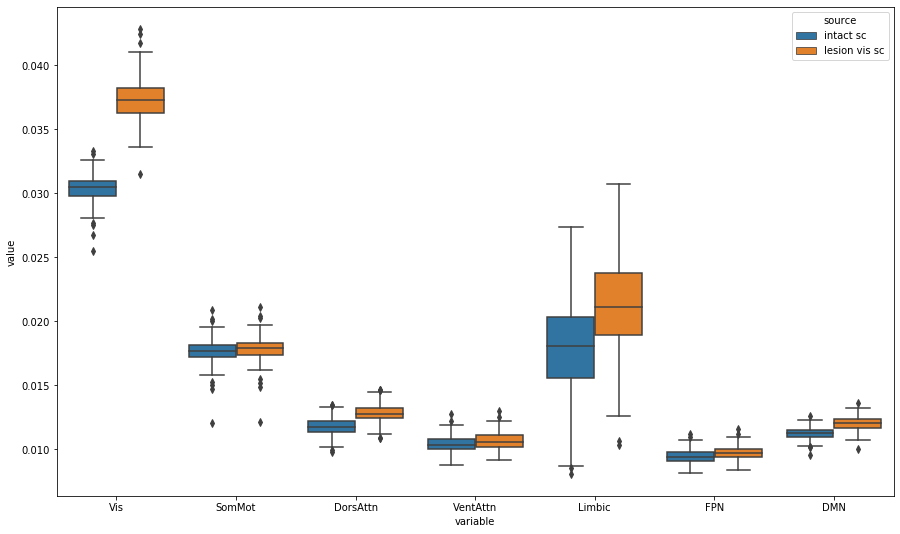

In [56]:
fig, ax = plt.subplots(figsize=(15,9))
ax = sns.boxplot(data=combined_df_long,x='variable',y='value',hue='source')


### bar plots

In [57]:
Ntwx = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

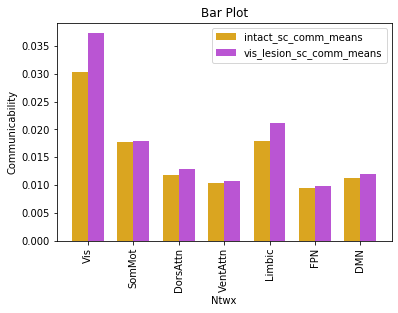

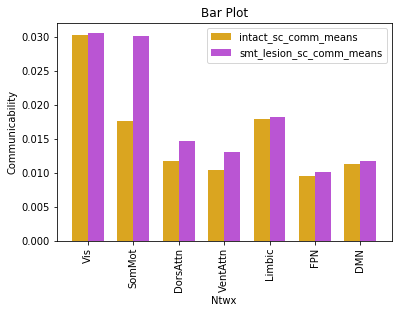

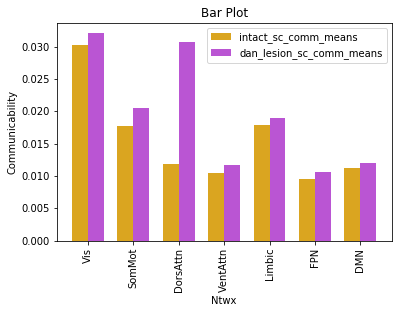

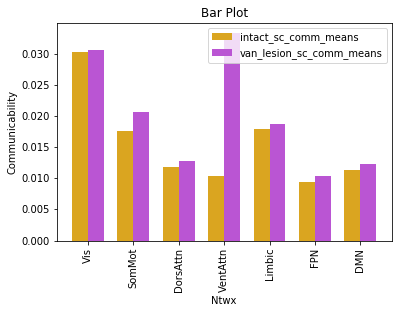

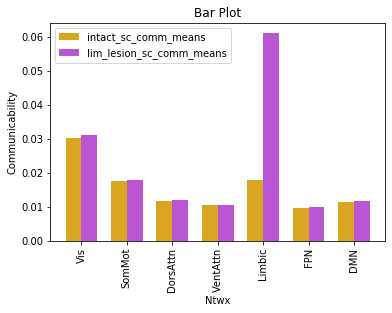

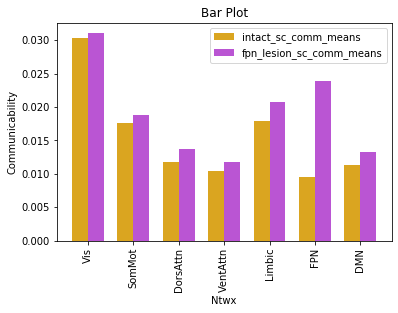

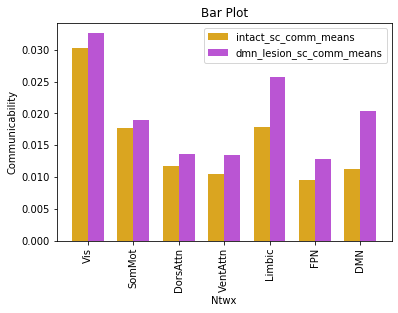

In [124]:
# Creating the bar plot
x = range(len(intact_sc_comm_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, intact_sc_comm_means, width, label='intact_sc_comm_means',color='goldenrod')
rects2 = ax.bar([i + width for i in x], vis_lesion_sc_comm_means, width, label='vis_lesion_sc_comm_means',color='mediumorchid')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Communicability')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend()

# Displaying the plot
plt.show()

#### Sommot

# Creating the bar plot
x = range(len(intact_sc_comm_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, intact_sc_comm_means, width, label='intact_sc_comm_means',color='goldenrod')
rects2 = ax.bar([i + width for i in x], smt_lesion_sc_comm_means, width, label='smt_lesion_sc_comm_means',color='mediumorchid')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Communicability')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend()

# Displaying the plot
plt.show()

#### Dorsattn

# Creating the bar plot
x = range(len(intact_sc_comm_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, intact_sc_comm_means, width, label='intact_sc_comm_means',color='goldenrod')
rects2 = ax.bar([i + width for i in x], dan_lesion_sc_comm_means, width, label='dan_lesion_sc_comm_means',color='mediumorchid')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Communicability')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend()

# Displaying the plot
plt.show()

#### Ventattn

# Creating the bar plot
x = range(len(intact_sc_comm_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, intact_sc_comm_means, width, label='intact_sc_comm_means',color='goldenrod')
rects2 = ax.bar([i + width for i in x], van_lesion_sc_comm_means, width, label='van_lesion_sc_comm_means',color='mediumorchid')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Communicability')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend()

# Displaying the plot
plt.show()

#### Limbic

# Creating the bar plot
x = range(len(intact_sc_comm_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, intact_sc_comm_means, width, label='intact_sc_comm_means',color='goldenrod')
rects2 = ax.bar([i + width for i in x], lim_lesion_sc_comm_means, width, label='lim_lesion_sc_comm_means',color='mediumorchid')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Communicability')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend()

# Displaying the plot
plt.show()

#### FPN

# Creating the bar plot
x = range(len(intact_sc_comm_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, intact_sc_comm_means, width, label='intact_sc_comm_means',color='goldenrod')
rects2 = ax.bar([i + width for i in x], fpn_lesion_sc_comm_means, width, label='fpn_lesion_sc_comm_means',color='mediumorchid')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Communicability')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend()

# Displaying the plot
plt.show()

#### DMN lesion

# Creating the bar plot
x = range(len(intact_sc_comm_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, intact_sc_comm_means, width, label='intact_sc_comm_means',color='goldenrod')
rects2 = ax.bar([i + width for i in x], dmn_lesion_sc_comm_means, width, label='dmn_lesion_sc_comm_means',color='mediumorchid')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Communicability')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend()

# Displaying the plot
plt.show()

## BETWEEN NTWX

In [208]:
def between_ntwx_only_sc(sc, sub, num):
    
    a, b, c, d = ntwx_labels_idxs[num]
    
    lh_ntwx_to_lh_vis = sc[sub][a:b, 0:14]
    lh_ntwx_to_rh_vis = sc[sub][a:b, 100:115]
    
    lh_ntwx_to_lh_sommot = sc[sub][a:b, 14:30]
    lh_ntwx_to_rh_sommot = sc[sub][a:b, 115:134]
    
    lh_ntwx_to_lh_dorsattn = sc[sub][a:b, 30:43]
    lh_ntwx_to_rh_dorsattn = sc[sub][a:b, 134:147]
    
    lh_ntwx_to_lh_ventattn = sc[sub][a:b, 43:54]
    lh_ntwx_to_rh_ventattn = sc[sub][a:b, 147:158]
    
    lh_ntwx_to_lh_limbic = sc[sub][a:b, 54:60]
    lh_ntwx_to_rh_limbic = sc[sub][a:b, 158:164]
    
    lh_ntwx_to_lh_fpn = sc[sub][a:b, 60:73]
    lh_ntwx_to_rh_fpn = sc[sub][a:b, 164:181]
    
    lh_ntwx_to_lh_dmn = sc[sub][a:b, 73:100]
    lh_ntwx_to_rh_dmn = sc[sub][a:b, 181:200]
    
    # ---------------------------------------------
    
    rh_ntwx_to_lh_vis = sc[sub][c:d, 0:14]
    rh_ntwx_to_rh_vis = sc[sub][c:d, 100:115]
    
    rh_ntwx_to_lh_sommot = sc[sub][c:d, 14:30]
    rh_ntwx_to_rh_sommot = sc[sub][c:d, 115:134]
    
    rh_ntwx_to_lh_dorsattn = sc[sub][c:d, 30:43]
    rh_ntwx_to_rh_dorsattn = sc[sub][c:d, 134:147]
    
    rh_ntwx_to_lh_ventattn = sc[sub][c:d, 43:54]
    rh_ntwx_to_rh_ventattn = sc[sub][c:d, 147:158]
    
    rh_ntwx_to_lh_limbic = sc[sub][c:d, 54:60]
    rh_ntwx_to_rh_limbic = sc[sub][c:d, 158:164]
    
    rh_ntwx_to_lh_fpn = sc[sub][c:d, 60:73]
    rh_ntwx_to_rh_fpn = sc[sub][c:d, 164:181]
    
    rh_ntwx_to_lh_dmn = sc[sub][c:d, 73:100]
    rh_ntwx_to_rh_dmn = sc[sub][c:d, 181:200]
        
    mean_ntwx_to_vis_sc = (np.mean(lh_ntwx_to_lh_vis) + (np.mean(lh_ntwx_to_rh_vis) + np.mean(rh_ntwx_to_lh_vis))/2 + np.mean(rh_ntwx_to_rh_vis))#/4
    mean_ntwx_to_sommot_sc = (np.mean(lh_ntwx_to_lh_sommot) + (np.mean(lh_ntwx_to_rh_sommot) + np.mean(rh_ntwx_to_lh_sommot))/2 + np.mean(rh_ntwx_to_rh_sommot))#/4
    mean_ntwx_to_dorsattn_sc = (np.mean(lh_ntwx_to_lh_dorsattn) + (np.mean(lh_ntwx_to_rh_dorsattn) + np.mean(rh_ntwx_to_lh_dorsattn))/2 + np.mean(rh_ntwx_to_rh_dorsattn))#/4
    mean_ntwx_to_ventattn_sc = (np.mean(lh_ntwx_to_lh_ventattn) + (np.mean(lh_ntwx_to_rh_ventattn) + np.mean(rh_ntwx_to_lh_ventattn))/2 + np.mean(rh_ntwx_to_rh_ventattn))#/4
    mean_ntwx_to_limbic_sc = (np.mean(lh_ntwx_to_lh_limbic) + (np.mean(lh_ntwx_to_rh_limbic) + np.mean(rh_ntwx_to_lh_limbic))/2 + np.mean(rh_ntwx_to_rh_limbic))#/4
    mean_ntwx_to_fpn_sc = (np.mean(lh_ntwx_to_lh_fpn) + (np.mean(lh_ntwx_to_rh_fpn) + np.mean(rh_ntwx_to_lh_fpn))/2 + np.mean(rh_ntwx_to_rh_fpn))#/4
    mean_ntwx_to_dmn_sc = (np.mean(lh_ntwx_to_lh_dmn) + (np.mean(lh_ntwx_to_rh_dmn) + np.mean(rh_ntwx_to_lh_dmn))/2 + np.mean(rh_ntwx_to_rh_dmn))#/4
    
    
    return mean_ntwx_to_vis_sc, mean_ntwx_to_sommot_sc, mean_ntwx_to_dorsattn_sc, mean_ntwx_to_ventattn_sc, mean_ntwx_to_limbic_sc, mean_ntwx_to_fpn_sc, mean_ntwx_to_dmn_sc

In [209]:
def get_between_ntwx_sc_communicability(sc):
    
    all_subs_vis_to_other_ntwx_lesions = []
    all_subs_smt_to_other_ntwx_lesions = []
    all_subs_dan_to_other_ntwx_lesions = []
    all_subs_van_to_other_ntwx_lesions = []
    all_subs_lim_to_other_ntwx_lesions = []
    all_subs_fpn_to_other_ntwx_lesions = []
    all_subs_dmn_to_other_ntwx_lesions = []

    for i in range(200):
        
        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,0)
        all_subs_vis_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,1)
        all_subs_smt_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,2)
        all_subs_dan_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,3)
        all_subs_van_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,4)
        all_subs_lim_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,5)
        all_subs_fpn_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,6)
        all_subs_dmn_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn
        
    mean_all_subs_vis_to_other_ntwx_lesions = np.mean(all_subs_vis_to_other_ntwx_lesions,axis=0)
    mean_all_subs_smt_to_other_ntwx_lesions = np.mean(all_subs_smt_to_other_ntwx_lesions,axis=0)
    mean_all_subs_dan_to_other_ntwx_lesions = np.mean(all_subs_dan_to_other_ntwx_lesions,axis=0)
    mean_all_subs_van_to_other_ntwx_lesions = np.mean(all_subs_van_to_other_ntwx_lesions,axis=0)
    mean_all_subs_lim_to_other_ntwx_lesions = np.mean(all_subs_lim_to_other_ntwx_lesions,axis=0)
    mean_all_subs_fpn_to_other_ntwx_lesions = np.mean(all_subs_fpn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_dmn_to_other_ntwx_lesions = np.mean(all_subs_dmn_to_other_ntwx_lesions,axis=0)
    
    return mean_all_subs_vis_to_other_ntwx_lesions,mean_all_subs_smt_to_other_ntwx_lesions,mean_all_subs_dan_to_other_ntwx_lesions,mean_all_subs_van_to_other_ntwx_lesions,mean_all_subs_lim_to_other_ntwx_lesions,mean_all_subs_fpn_to_other_ntwx_lesions,mean_all_subs_dmn_to_other_ntwx_lesions

In [210]:
def get_between_ntwx_sc_communicability_all_subs(sc):
    
    all_subs_vis_to_other_ntwx_lesions = []
    all_subs_smt_to_other_ntwx_lesions = []
    all_subs_dan_to_other_ntwx_lesions = []
    all_subs_van_to_other_ntwx_lesions = []
    all_subs_lim_to_other_ntwx_lesions = []
    all_subs_fpn_to_other_ntwx_lesions = []
    all_subs_dmn_to_other_ntwx_lesions = []

    for i in range(200):
        
        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,0)
        all_subs_vis_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,1)
        all_subs_smt_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,2)
        all_subs_dan_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,3)
        all_subs_van_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,4)
        all_subs_lim_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,5)
        all_subs_fpn_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,6)
        all_subs_dmn_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn
        

    return  all_subs_vis_to_other_ntwx_lesions, all_subs_smt_to_other_ntwx_lesions, all_subs_dan_to_other_ntwx_lesions, all_subs_van_to_other_ntwx_lesions, all_subs_lim_to_other_ntwx_lesions, all_subs_fpn_to_other_ntwx_lesions, all_subs_dmn_to_other_ntwx_lesions

In [211]:
%%time

# a,b,c,d,e,f,g = get_outer_ntwx_fc(all_subs_og_whobpyt)

intact_sc_vis_to_other_ntwx, intact_sc_smt_to_other_ntwx, intact_sc_dan_to_other_ntwx, intact_sc_van_to_other_ntwx, intact_sc_lim_to_other_ntwx, intact_sc_fpn_to_other_ntwx, intact_sc_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc)

vis_lesion_vis_to_other_ntwx, vis_lesion_smt_to_other_ntwx, vis_lesion_dan_to_other_ntwx, vis_lesion_van_to_other_ntwx, vis_lesion_lim_to_other_ntwx, vis_lesion_fpn_to_other_ntwx, vis_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_vis_lesion)

smt_lesion_vis_to_other_ntwx, smt_lesion_smt_to_other_ntwx, smt_lesion_dan_to_other_ntwx, smt_lesion_van_to_other_ntwx, smt_lesion_lim_to_other_ntwx, smt_lesion_fpn_to_other_ntwx, smt_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_smt_lesion)

dan_lesion_vis_to_other_ntwx, dan_lesion_smt_to_other_ntwx, dan_lesion_dan_to_other_ntwx, dan_lesion_van_to_other_ntwx, dan_lesion_lim_to_other_ntwx, dan_lesion_fpn_to_other_ntwx, dan_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_dan_lesion)

van_lesion_vis_to_other_ntwx, van_lesion_smt_to_other_ntwx, van_lesion_dan_to_other_ntwx, van_lesion_van_to_other_ntwx, van_lesion_lim_to_other_ntwx, van_lesion_fpn_to_other_ntwx, van_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_van_lesion)

lim_lesion_vis_to_other_ntwx, lim_lesion_smt_to_other_ntwx, lim_lesion_dan_to_other_ntwx, lim_lesion_van_to_other_ntwx, lim_lesion_lim_to_other_ntwx, lim_lesion_fpn_to_other_ntwx, lim_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_lim_lesion)

fpn_lesion_vis_to_other_ntwx, fpn_lesion_smt_to_other_ntwx, fpn_lesion_dan_to_other_ntwx, fpn_lesion_van_to_other_ntwx, fpn_lesion_lim_to_other_ntwx, fpn_lesion_fpn_to_other_ntwx, fpn_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_fpn_lesion)

dmn_lesion_vis_to_other_ntwx, dmn_lesion_smt_to_other_ntwx, dmn_lesion_dan_to_other_ntwx, dmn_lesion_van_to_other_ntwx, dmn_lesion_lim_to_other_ntwx, dmn_lesion_fpn_to_other_ntwx, dmn_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_dmn_lesion)

CPU times: user 6.55 s, sys: 81.2 ms, total: 6.63 s
Wall time: 6.61 s


In [212]:
intact_sc_between_other_ntwx = [intact_sc_vis_to_other_ntwx, intact_sc_smt_to_other_ntwx, intact_sc_dan_to_other_ntwx, intact_sc_van_to_other_ntwx, intact_sc_lim_to_other_ntwx, intact_sc_fpn_to_other_ntwx, intact_sc_dmn_to_other_ntwx]

vis_lesion_between_other_ntwx = [vis_lesion_vis_to_other_ntwx, vis_lesion_smt_to_other_ntwx, vis_lesion_dan_to_other_ntwx, vis_lesion_van_to_other_ntwx, vis_lesion_lim_to_other_ntwx, vis_lesion_fpn_to_other_ntwx, vis_lesion_dmn_to_other_ntwx]
smt_lesion_between_other_ntwx = [smt_lesion_vis_to_other_ntwx, smt_lesion_smt_to_other_ntwx, smt_lesion_dan_to_other_ntwx, smt_lesion_van_to_other_ntwx, smt_lesion_lim_to_other_ntwx, smt_lesion_fpn_to_other_ntwx, smt_lesion_dmn_to_other_ntwx]
dan_lesion_between_other_ntwx = [dan_lesion_vis_to_other_ntwx, dan_lesion_smt_to_other_ntwx, dan_lesion_dan_to_other_ntwx, dan_lesion_van_to_other_ntwx, dan_lesion_lim_to_other_ntwx, dan_lesion_fpn_to_other_ntwx, dan_lesion_dmn_to_other_ntwx]
van_lesion_between_other_ntwx = [van_lesion_vis_to_other_ntwx, van_lesion_smt_to_other_ntwx, van_lesion_dan_to_other_ntwx, van_lesion_van_to_other_ntwx, van_lesion_lim_to_other_ntwx, van_lesion_fpn_to_other_ntwx, van_lesion_dmn_to_other_ntwx]
lim_lesion_between_other_ntwx = [lim_lesion_vis_to_other_ntwx, lim_lesion_smt_to_other_ntwx, lim_lesion_dan_to_other_ntwx, lim_lesion_van_to_other_ntwx, lim_lesion_lim_to_other_ntwx, lim_lesion_fpn_to_other_ntwx, lim_lesion_dmn_to_other_ntwx]
fpn_lesion_between_other_ntwx = [fpn_lesion_vis_to_other_ntwx, fpn_lesion_smt_to_other_ntwx, fpn_lesion_dan_to_other_ntwx, fpn_lesion_van_to_other_ntwx, fpn_lesion_lim_to_other_ntwx, fpn_lesion_fpn_to_other_ntwx, fpn_lesion_dmn_to_other_ntwx]
dmn_lesion_between_other_ntwx = [dmn_lesion_vis_to_other_ntwx, dmn_lesion_smt_to_other_ntwx, dmn_lesion_dan_to_other_ntwx, dmn_lesion_van_to_other_ntwx, dmn_lesion_lim_to_other_ntwx, dmn_lesion_fpn_to_other_ntwx, dmn_lesion_dmn_to_other_ntwx]

In [213]:
intact_sc_between_other_ntwx = [arr.tolist() for arr in intact_sc_between_other_ntwx]

vis_lesion_between_other_ntwx = [arr.tolist() for arr in vis_lesion_between_other_ntwx]
smt_lesion_between_other_ntwx = [arr.tolist() for arr in smt_lesion_between_other_ntwx]
dan_lesion_between_other_ntwx = [arr.tolist() for arr in dan_lesion_between_other_ntwx]
van_lesion_between_other_ntwx = [arr.tolist() for arr in van_lesion_between_other_ntwx]
lim_lesion_between_other_ntwx = [arr.tolist() for arr in lim_lesion_between_other_ntwx]
fpn_lesion_between_other_ntwx = [arr.tolist() for arr in fpn_lesion_between_other_ntwx]
dmn_lesion_between_other_ntwx = [arr.tolist() for arr in dmn_lesion_between_other_ntwx]

In [214]:
### 0-----------------------------------------------------------------------------------------------

In [215]:
%%time

# For stats

intact_sc_all_subs_vis_to_other_ntwx, intact_sc_all_subs_smt_to_other_ntwx, intact_sc_all_subs_dan_to_other_ntwx, intact_sc_all_subs_van_to_other_ntwx, intact_sc_all_subs_lim_to_other_ntwx, intact_sc_all_subs_fpn_to_other_ntwx, intact_sc_all_subs_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_all_subs(all_subs_communicability_sc)

vis_lesion_all_subs_vis_to_other_ntwx, vis_lesion_all_subs_smt_to_other_ntwx, vis_lesion_all_subs_dan_to_other_ntwx, vis_lesion_all_subs_van_to_other_ntwx, vis_lesion_all_subs_lim_to_other_ntwx, vis_lesion_all_subs_fpn_to_other_ntwx, vis_lesion_all_subs_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_all_subs(all_subs_communicability_sc_vis_lesion)

smt_lesion_all_subs_vis_to_other_ntwx, smt_lesion_all_subs_smt_to_other_ntwx, smt_lesion_all_subs_dan_to_other_ntwx, smt_lesion_all_subs_van_to_other_ntwx, smt_lesion_all_subs_lim_to_other_ntwx, smt_lesion_all_subs_fpn_to_other_ntwx, smt_lesion_all_subs_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_all_subs(all_subs_communicability_sc_smt_lesion)

dan_lesion_all_subs_vis_to_other_ntwx, dan_lesion_all_subs_smt_to_other_ntwx, dan_lesion_all_subs_dan_to_other_ntwx, dan_lesion_all_subs_van_to_other_ntwx, dan_lesion_all_subs_lim_to_other_ntwx, dan_lesion_all_subs_fpn_to_other_ntwx, dan_lesion_all_subs_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_all_subs(all_subs_communicability_sc_dan_lesion)

van_lesion_all_subs_vis_to_other_ntwx, van_lesion_all_subs_smt_to_other_ntwx, van_lesion_all_subs_dan_to_other_ntwx, van_lesion_all_subs_van_to_other_ntwx, van_lesion_all_subs_lim_to_other_ntwx, van_lesion_all_subs_fpn_to_other_ntwx, van_lesion_all_subs_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_all_subs(all_subs_communicability_sc_van_lesion)

lim_lesion_all_subs_vis_to_other_ntwx, lim_lesion_all_subs_smt_to_other_ntwx, lim_lesion_all_subs_dan_to_other_ntwx, lim_lesion_all_subs_van_to_other_ntwx, lim_lesion_all_subs_lim_to_other_ntwx, lim_lesion_all_subs_fpn_to_other_ntwx, lim_lesion_all_subs_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_all_subs(all_subs_communicability_sc_lim_lesion)

fpn_lesion_all_subs_vis_to_other_ntwx, fpn_lesion_all_subs_smt_to_other_ntwx, fpn_lesion_all_subs_dan_to_other_ntwx, fpn_lesion_all_subs_van_to_other_ntwx, fpn_lesion_all_subs_lim_to_other_ntwx, fpn_lesion_all_subs_fpn_to_other_ntwx, fpn_lesion_all_subs_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_all_subs(all_subs_communicability_sc_fpn_lesion)

dmn_lesion_all_subs_vis_to_other_ntwx, dmn_lesion_all_subs_smt_to_other_ntwx, dmn_lesion_all_subs_dan_to_other_ntwx, dmn_lesion_all_subs_van_to_other_ntwx, dmn_lesion_all_subs_lim_to_other_ntwx, dmn_lesion_all_subs_fpn_to_other_ntwx, dmn_lesion_all_subs_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_all_subs(all_subs_communicability_sc_dmn_lesion)

CPU times: user 6.49 s, sys: 79.4 ms, total: 6.57 s
Wall time: 6.53 s


In [216]:
intact_sc_all_subs_between_other_ntwx = [intact_sc_all_subs_vis_to_other_ntwx, intact_sc_all_subs_smt_to_other_ntwx, intact_sc_all_subs_dan_to_other_ntwx, intact_sc_all_subs_van_to_other_ntwx, intact_sc_all_subs_lim_to_other_ntwx, intact_sc_all_subs_fpn_to_other_ntwx, intact_sc_all_subs_dmn_to_other_ntwx]

vis_lesion_all_subs_between_other_ntwx = [vis_lesion_all_subs_vis_to_other_ntwx, vis_lesion_all_subs_smt_to_other_ntwx, vis_lesion_all_subs_dan_to_other_ntwx, vis_lesion_all_subs_van_to_other_ntwx, vis_lesion_all_subs_lim_to_other_ntwx, vis_lesion_all_subs_fpn_to_other_ntwx, vis_lesion_all_subs_dmn_to_other_ntwx]
smt_lesion_all_subs_between_other_ntwx = [smt_lesion_all_subs_vis_to_other_ntwx, smt_lesion_all_subs_smt_to_other_ntwx, smt_lesion_all_subs_dan_to_other_ntwx, smt_lesion_all_subs_van_to_other_ntwx, smt_lesion_all_subs_lim_to_other_ntwx, smt_lesion_all_subs_fpn_to_other_ntwx, smt_lesion_all_subs_dmn_to_other_ntwx]
dan_lesion_all_subs_between_other_ntwx = [dan_lesion_all_subs_vis_to_other_ntwx, dan_lesion_all_subs_smt_to_other_ntwx, dan_lesion_all_subs_dan_to_other_ntwx, dan_lesion_all_subs_van_to_other_ntwx, dan_lesion_all_subs_lim_to_other_ntwx, dan_lesion_all_subs_fpn_to_other_ntwx, dan_lesion_all_subs_dmn_to_other_ntwx]
van_lesion_all_subs_between_other_ntwx = [van_lesion_all_subs_vis_to_other_ntwx, van_lesion_all_subs_smt_to_other_ntwx, van_lesion_all_subs_dan_to_other_ntwx, van_lesion_all_subs_van_to_other_ntwx, van_lesion_all_subs_lim_to_other_ntwx, van_lesion_all_subs_fpn_to_other_ntwx, van_lesion_all_subs_dmn_to_other_ntwx]
lim_lesion_all_subs_between_other_ntwx = [lim_lesion_all_subs_vis_to_other_ntwx, lim_lesion_all_subs_smt_to_other_ntwx, lim_lesion_all_subs_dan_to_other_ntwx, lim_lesion_all_subs_van_to_other_ntwx, lim_lesion_all_subs_lim_to_other_ntwx, lim_lesion_all_subs_fpn_to_other_ntwx, lim_lesion_all_subs_dmn_to_other_ntwx]
fpn_lesion_all_subs_between_other_ntwx = [fpn_lesion_all_subs_vis_to_other_ntwx, fpn_lesion_all_subs_smt_to_other_ntwx, fpn_lesion_all_subs_dan_to_other_ntwx, fpn_lesion_all_subs_van_to_other_ntwx, fpn_lesion_all_subs_lim_to_other_ntwx, fpn_lesion_all_subs_fpn_to_other_ntwx, fpn_lesion_all_subs_dmn_to_other_ntwx]
dmn_lesion_all_subs_between_other_ntwx = [dmn_lesion_all_subs_vis_to_other_ntwx, dmn_lesion_all_subs_smt_to_other_ntwx, dmn_lesion_all_subs_dan_to_other_ntwx, dmn_lesion_all_subs_van_to_other_ntwx, dmn_lesion_all_subs_lim_to_other_ntwx, dmn_lesion_all_subs_fpn_to_other_ntwx, dmn_lesion_all_subs_dmn_to_other_ntwx]

#### Visual 

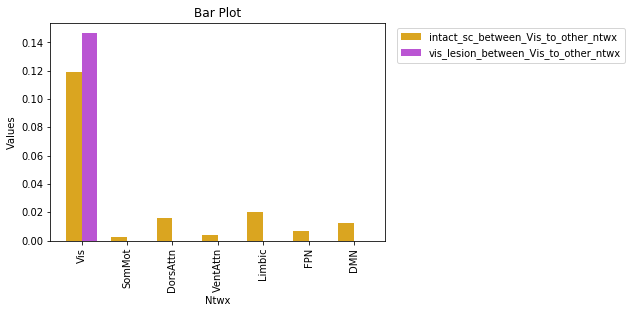

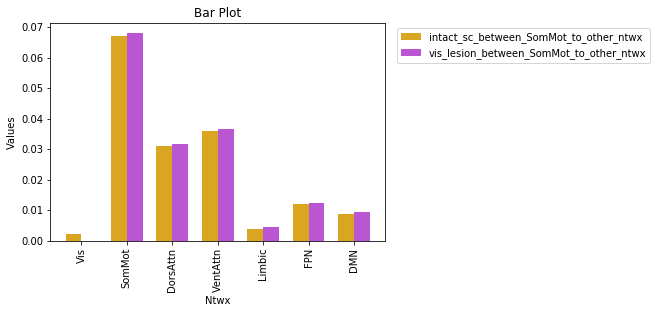

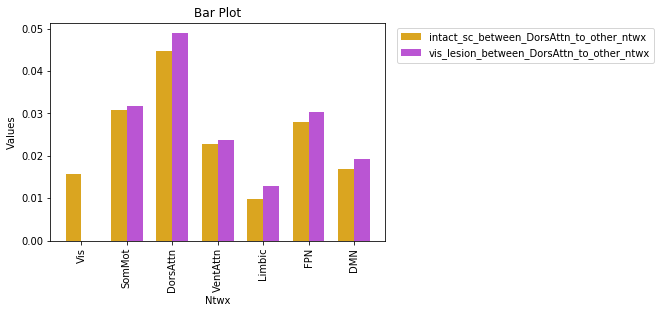

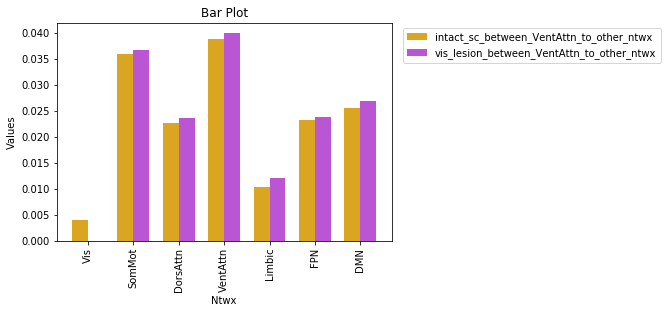

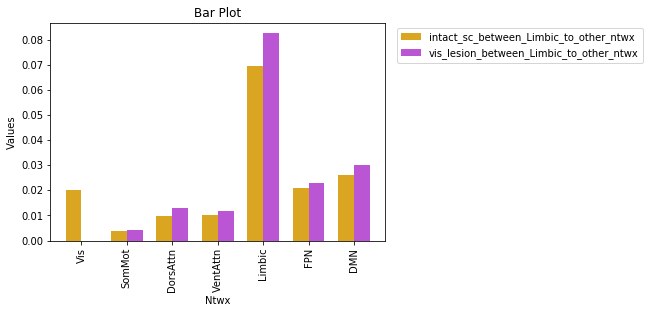

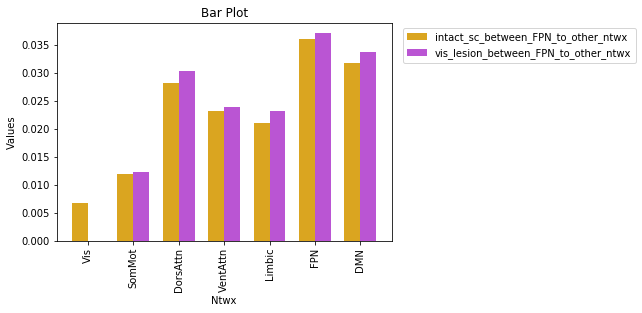

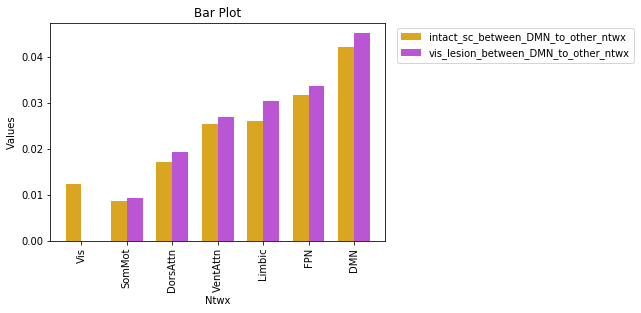

In [217]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, intact_sc_between_other_ntwx[j], width, label='intact_sc_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='goldenrod')
    rects2 = ax.bar([i + width for i in x], vis_lesion_between_other_ntwx[j], width, label='vis_lesion_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='mediumorchid')
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### SomatoMotor

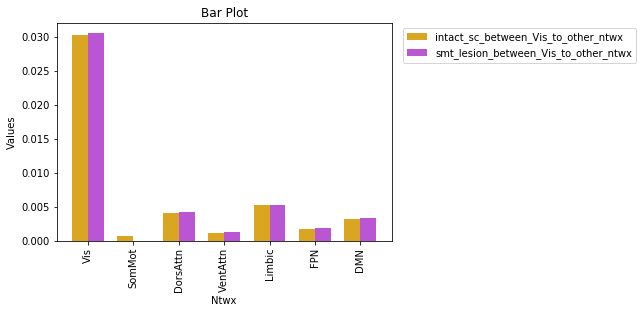

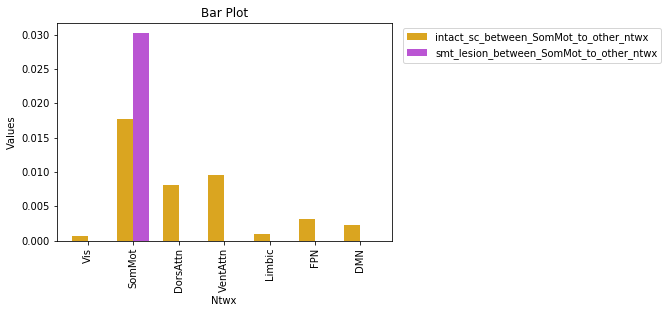

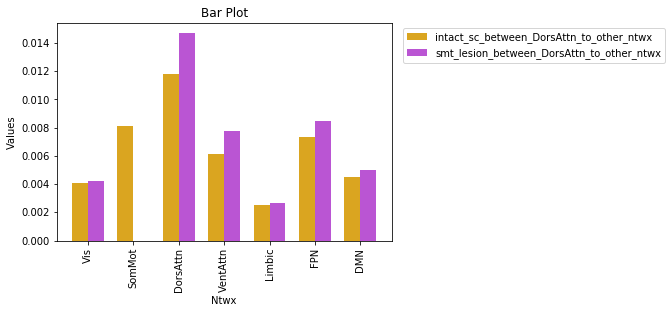

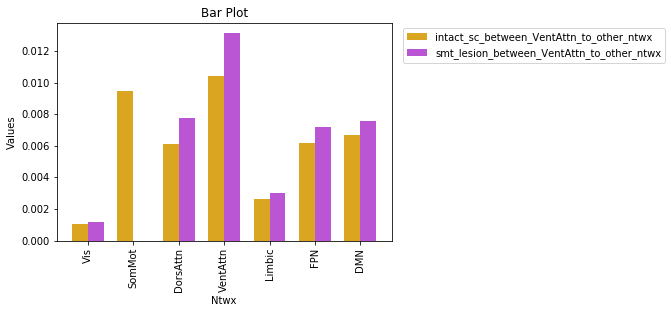

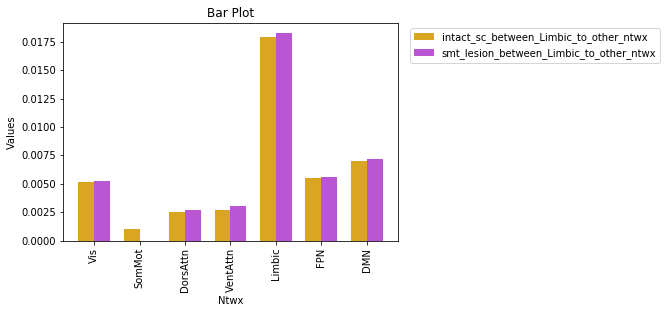

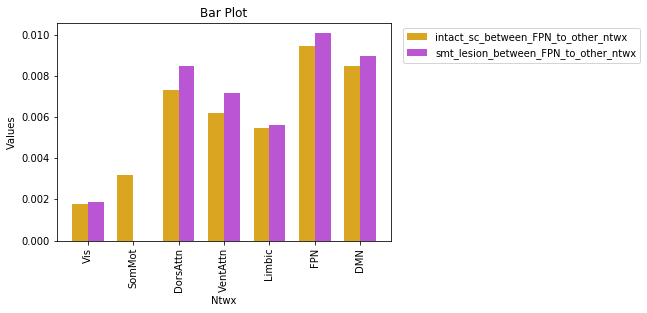

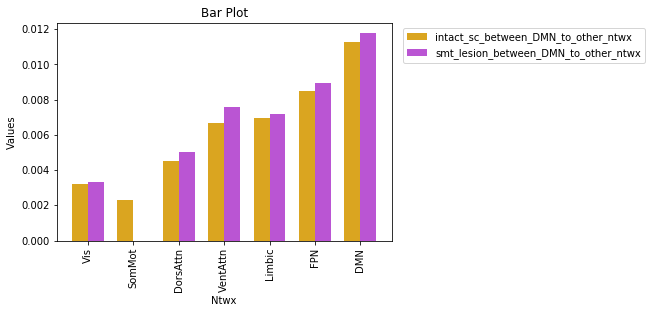

In [67]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, intact_sc_between_other_ntwx[j], width, label='intact_sc_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='goldenrod')
    rects2 = ax.bar([i + width for i in x], smt_lesion_between_other_ntwx[j], width, label='smt_lesion_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='mediumorchid')
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### DAN

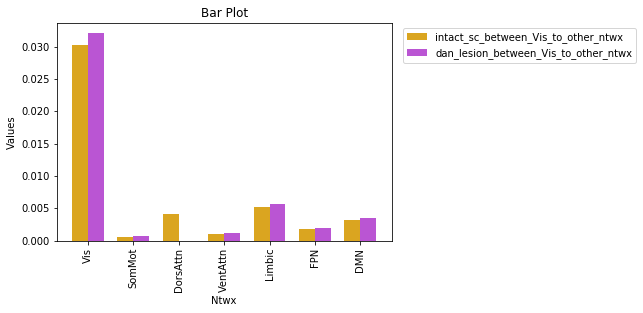

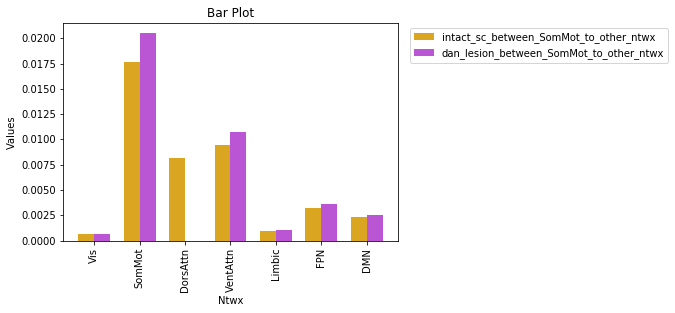

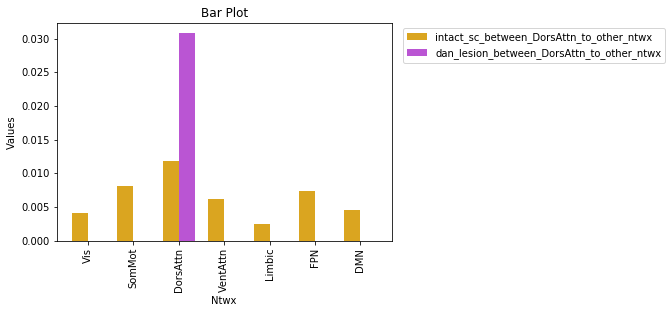

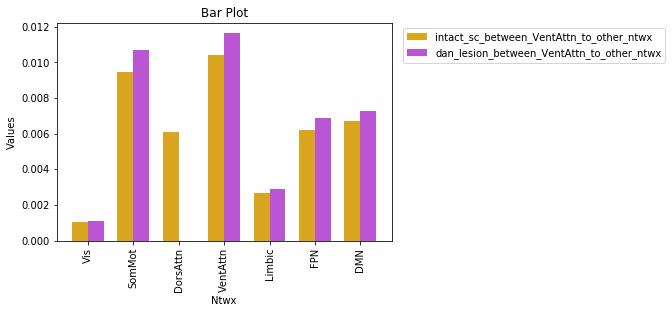

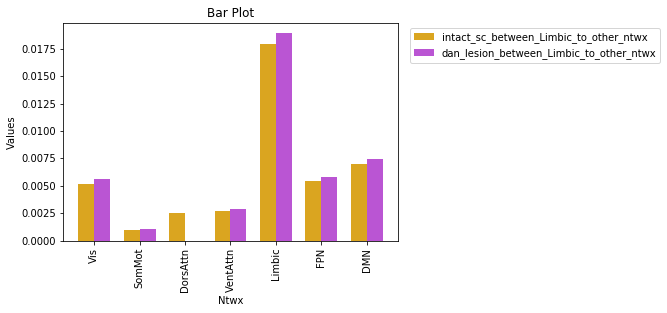

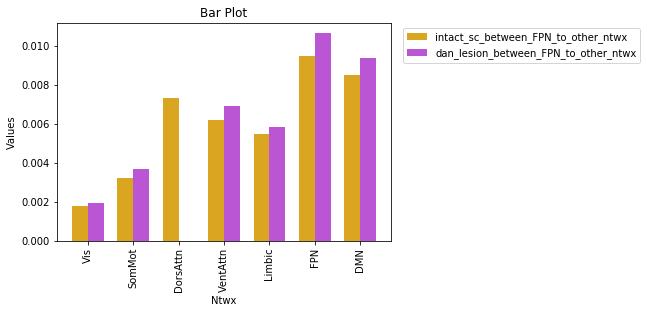

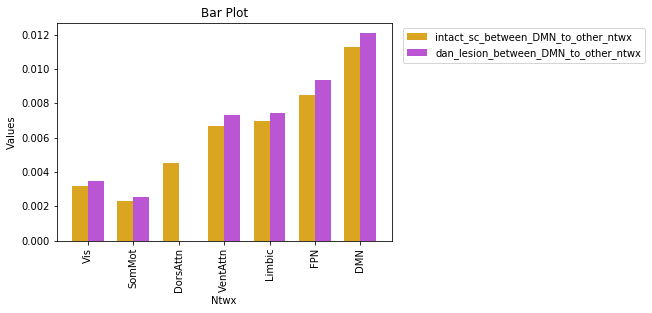

In [68]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, intact_sc_between_other_ntwx[j], width, label='intact_sc_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='goldenrod')
    rects2 = ax.bar([i + width for i in x], dan_lesion_between_other_ntwx[j], width, label='dan_lesion_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='mediumorchid')
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### VAN

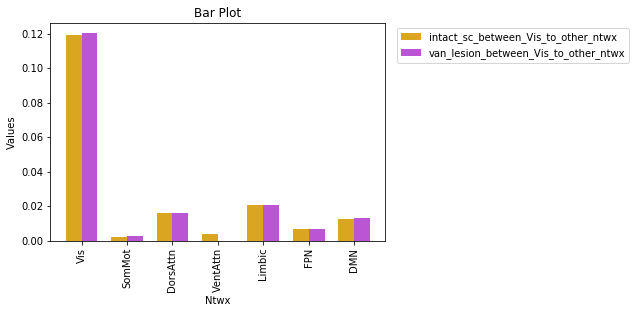

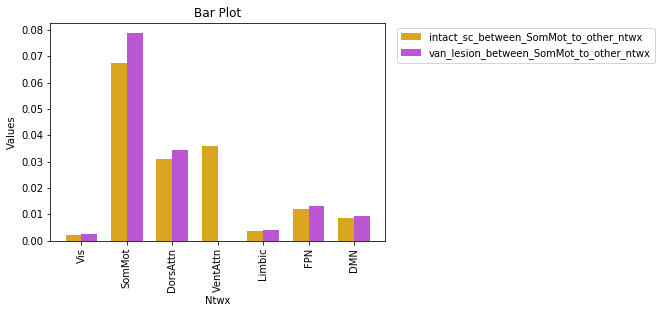

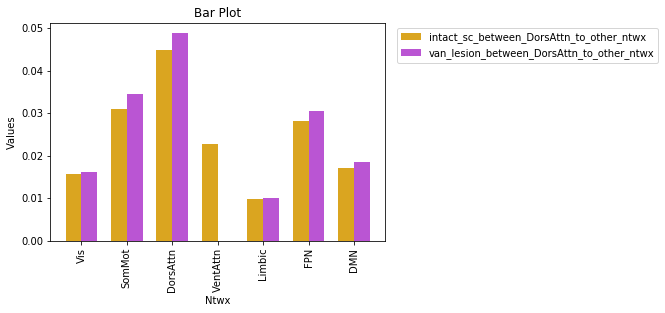

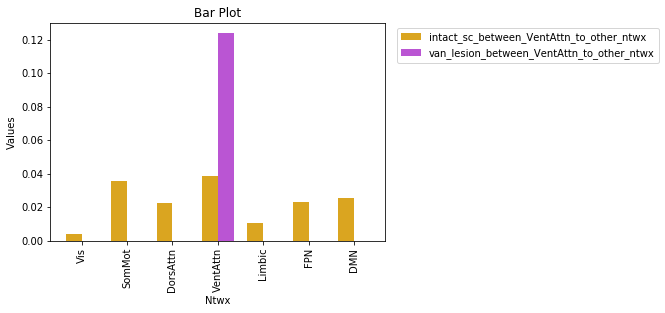

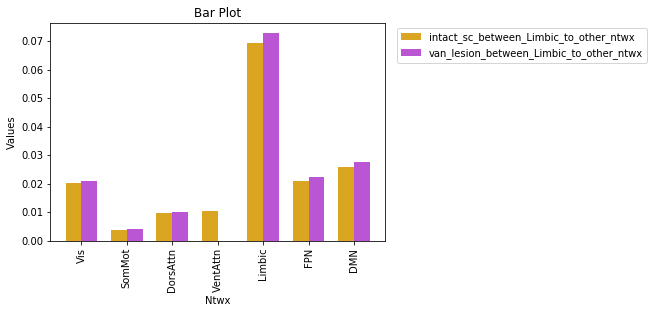

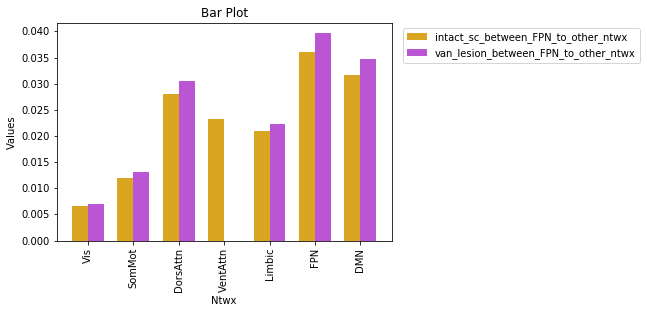

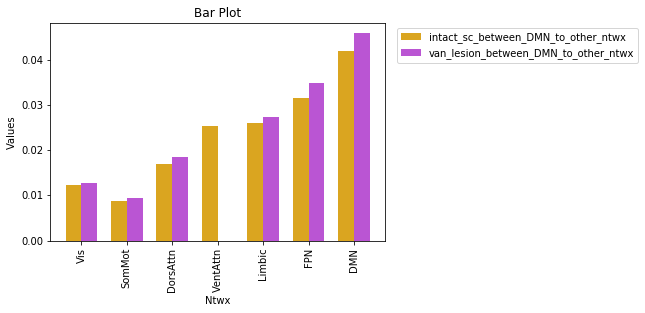

In [226]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, intact_sc_between_other_ntwx[j], width, label='intact_sc_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='goldenrod')
    rects2 = ax.bar([i + width for i in x], van_lesion_between_other_ntwx[j], width, label='van_lesion_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='mediumorchid')
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### lim

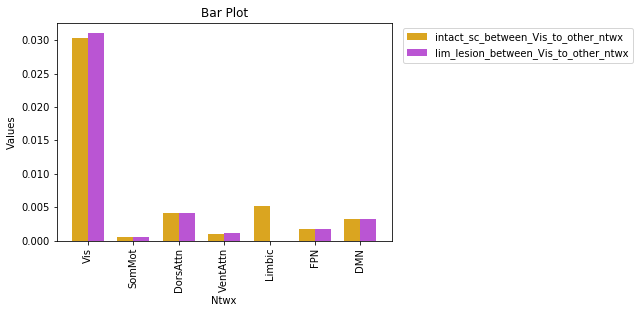

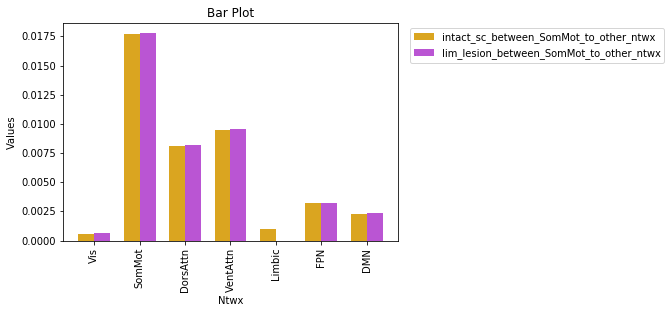

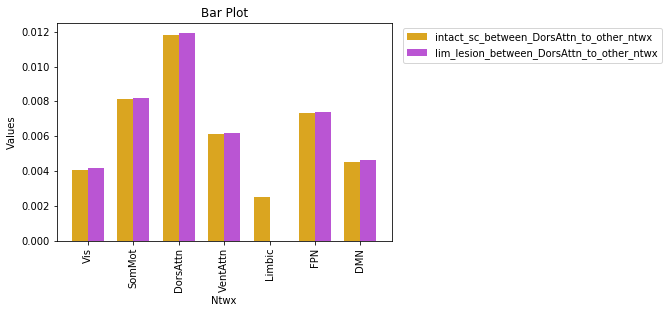

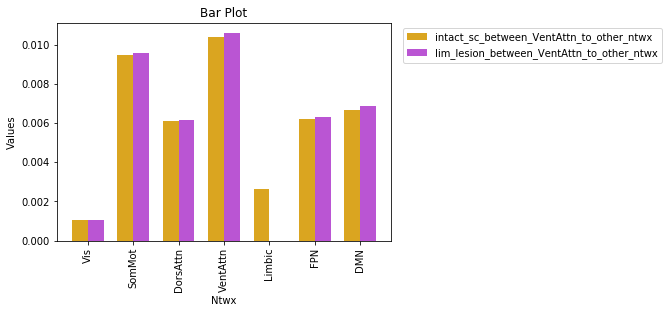

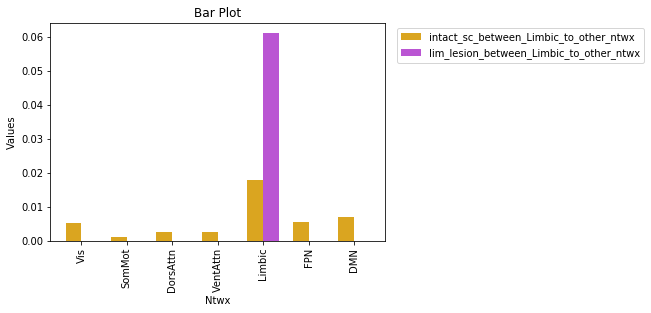

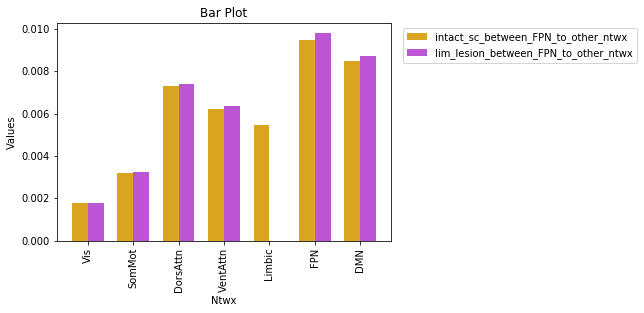

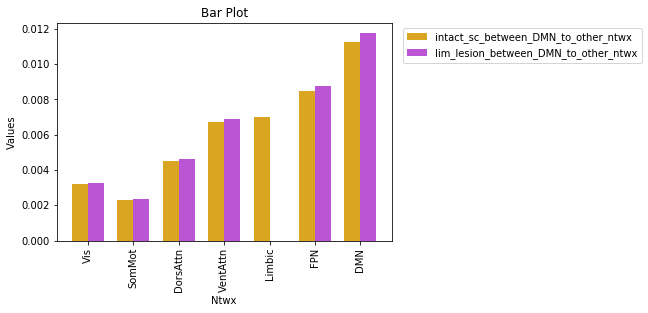

In [70]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, intact_sc_between_other_ntwx[j], width, label='intact_sc_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='goldenrod')
    rects2 = ax.bar([i + width for i in x], lim_lesion_between_other_ntwx[j], width, label='lim_lesion_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='mediumorchid')
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### FPN

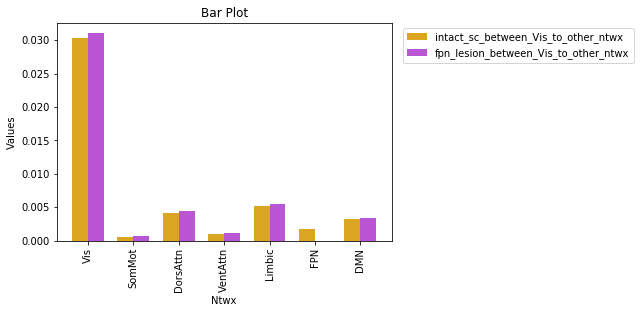

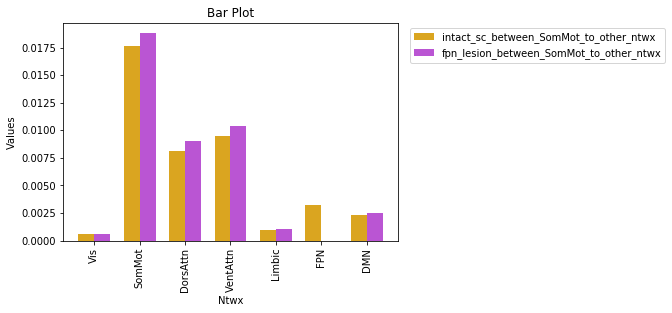

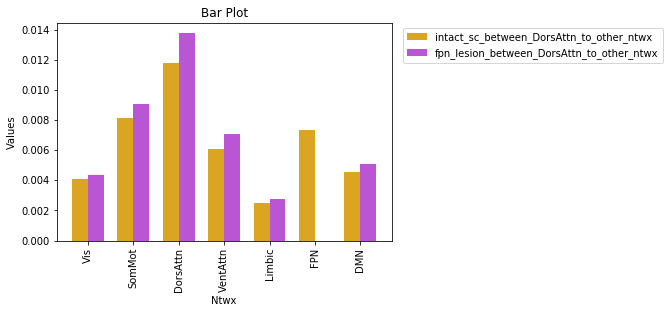

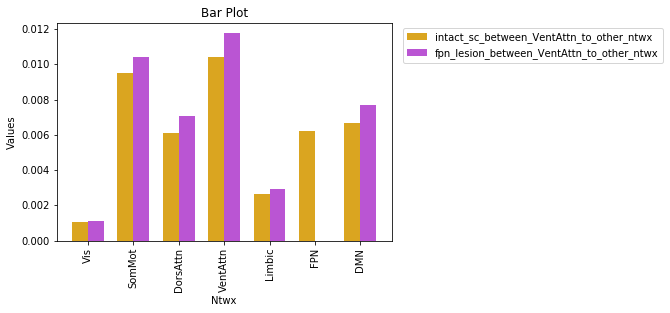

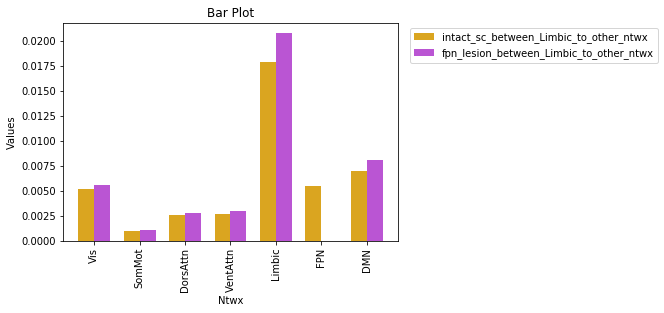

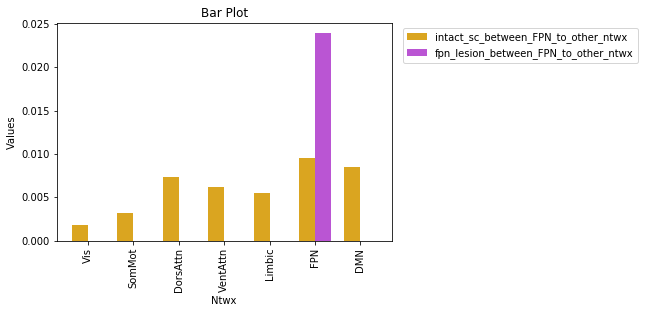

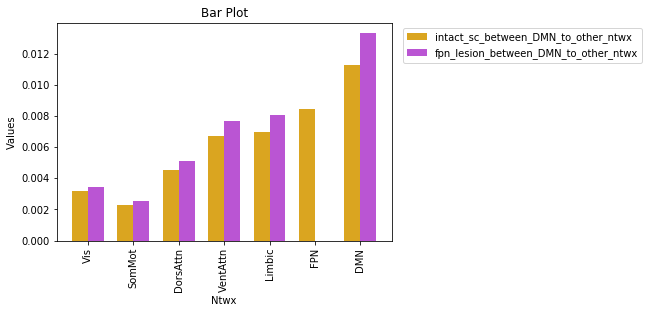

In [71]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, intact_sc_between_other_ntwx[j], width, label='intact_sc_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='goldenrod')
    rects2 = ax.bar([i + width for i in x], fpn_lesion_between_other_ntwx[j], width, label='fpn_lesion_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='mediumorchid')
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### DMN

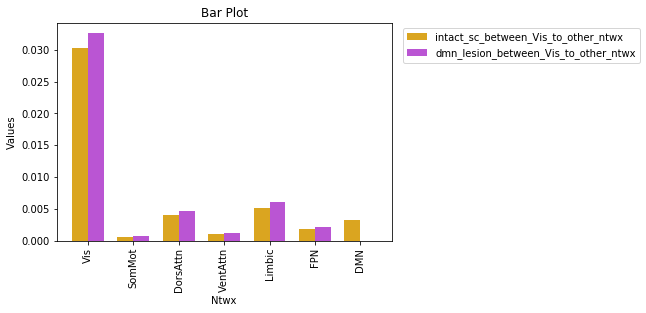

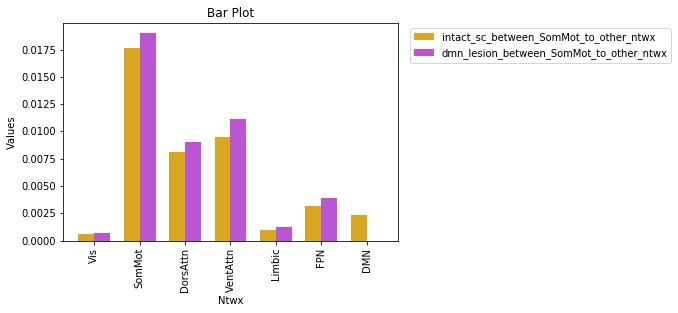

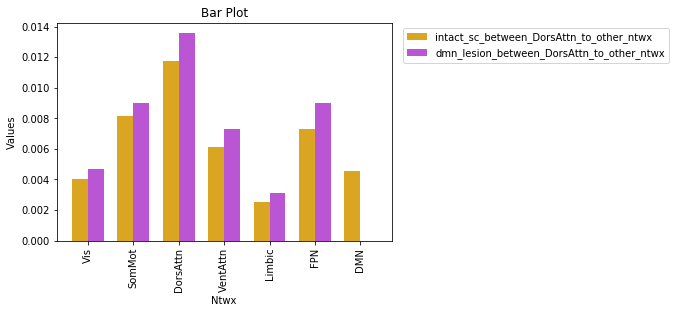

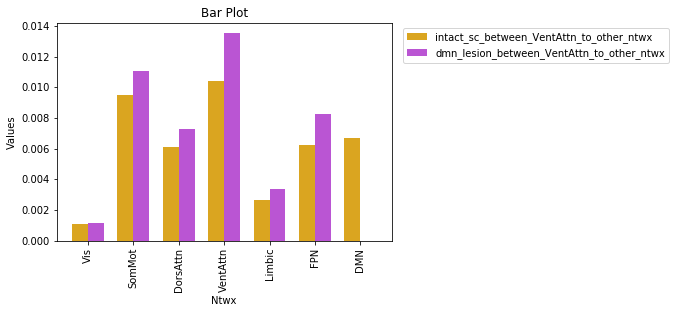

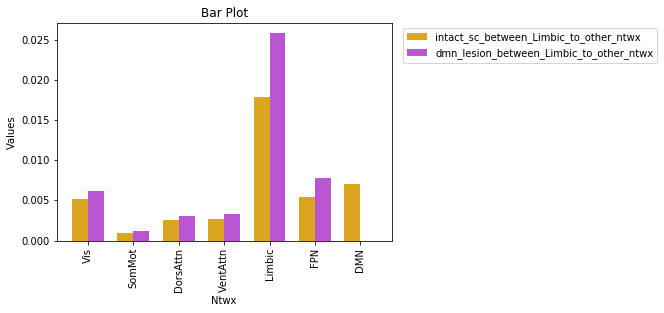

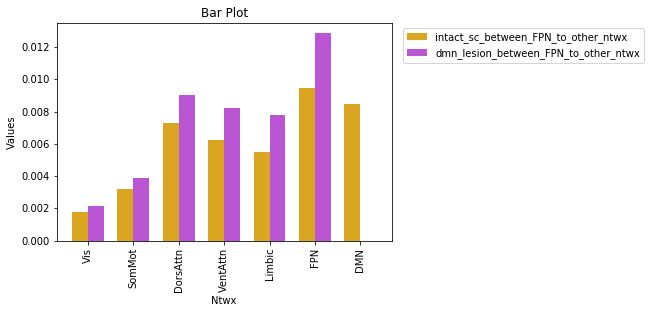

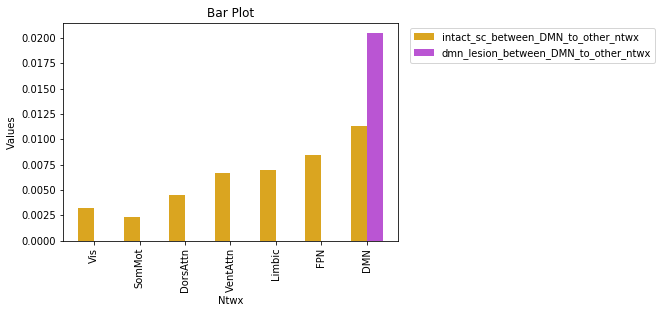

In [72]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, intact_sc_between_other_ntwx[j], width, label='intact_sc_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='goldenrod')
    rects2 = ax.bar([i + width for i in x], dmn_lesion_between_other_ntwx[j], width, label='dmn_lesion_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='mediumorchid')
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

## Stats

In [ ]:
# intact_sc_all_subs_between_other_ntwx
# vis_lesion_all_subs_between_other_ntwx

In [153]:
# vis

In [219]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    t_stat, p_val = stats.ttest_ind(intact_sc_all_subs_between_other_ntwx[i], vis_lesion_all_subs_between_other_ntwx[i])
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    
    print(p_val)
    print(p_val_formatted)
    
    
    print('--------------------- \n')

Vis to other ntwx stats 

[-53.1684538   54.37064512 150.70946742  73.21788657  76.48680275
  86.942482   123.23223071]
[6.49514925e-183 2.59648547e-186 0.00000000e+000 4.86380545e-233
 4.33527812e-240 5.50139168e-261 4.36437829e-319]
['0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000']
--------------------- 

SomMot to other ntwx stats 

[54.37064512 -2.05078441 -4.87757787 -3.04795569 -4.35796392 -2.66415907
 -7.04747628]
[2.59648547e-186 4.09422660e-002 1.55563443e-006 2.45777864e-003
 1.67300385e-005 8.03176590e-003 8.08258554e-012]
['0.0000000000', '0.0409422660', '0.0000015556', '0.0024577786', '0.0000167300', '0.0080317659', '0.0000000000']
--------------------- 

DorsAttn to other ntwx stats 

[150.70946742  -4.87757787 -14.29670598  -5.92969496 -14.84888638
 -14.71399212 -17.82670258]
[0.00000000e+00 1.55563443e-06 1.03411180e-37 6.59093904e-09
 5.31333700e-40 1.93614938e-39 1.12442437e-52]
['0.0000000000', '0.0000015

In [220]:
# smt

In [221]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    t_stat, p_val = stats.ttest_ind(intact_sc_all_subs_between_other_ntwx[i], smt_lesion_all_subs_between_other_ntwx[i])
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    
    print(p_val)
    print(p_val_formatted)
    
    
    print('--------------------- \n')

Vis to other ntwx stats 

[-1.87136564 54.37064512 -3.85979251 -6.26229765 -1.07452749 -2.65848196
 -2.85311198]
[6.20278069e-002 2.59648547e-186 1.32377613e-004 9.84208641e-010
 2.83237326e-001 8.16589394e-003 4.55534061e-003]
['0.0620278069', '0.0000000000', '0.0001323776', '0.0000000010', '0.2832373258', '0.0081658939', '0.0045553406']
--------------------- 

SomMot to other ntwx stats 

[ 54.37064512 -97.89830408 283.5082663  195.13362455  42.37712884
 129.25146026 146.94506452]
[2.59648547e-186 1.38764041e-280 0.00000000e+000 0.00000000e+000
 1.32631671e-149 0.00000000e+000 0.00000000e+000]
['0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000']
--------------------- 

DorsAttn to other ntwx stats 

[ -3.85979251 283.5082663  -35.44929806 -33.17897214  -2.93731934
 -27.07469178 -13.59224167]
[1.32377613e-004 0.00000000e+000 3.27487199e-125 1.17365199e-116
 3.50308389e-003 2.69160465e-092 7.84815299e-035]
['0.0001323776', '0.

In [222]:
# dan

In [223]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    t_stat, p_val = stats.ttest_ind(intact_sc_all_subs_between_other_ntwx[i], dan_lesion_all_subs_between_other_ntwx[i])
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    
    print(p_val)
    print(p_val_formatted)
    
    
    print('--------------------- \n')

Vis to other ntwx stats 

[-15.32987808  -2.37591901 150.70946742  -2.6815854   -4.4020289
  -4.32716794  -6.65510037]
[5.14942944e-42 1.79778736e-02 0.00000000e+00 7.63232870e-03
 1.37952409e-05 1.91261484e-05 9.39950617e-11]
['0.0000000000', '0.0179778736', '0.0000000000', '0.0076323287', '0.0000137952', '0.0000191261', '0.0000000001']
--------------------- 

SomMot to other ntwx stats 

[ -2.37591901 -28.21461217 283.5082663  -16.42275123  -2.97538352
 -12.06699524  -9.83326712]
[1.79778736e-02 5.46308179e-97 0.00000000e+00 1.20544575e-46
 3.10467307e-03 8.68973084e-29 1.43128133e-20]
['0.0179778736', '0.0000000000', '0.0000000000', '0.0000000000', '0.0031046731', '0.0000000000', '0.0000000000']
--------------------- 

DorsAttn to other ntwx stats 

[ 150.70946742  283.5082663  -116.84661502  202.26575147   81.16219765
  265.03992236  199.91353804]
[0.00000000e+000 0.00000000e+000 3.89149919e-310 0.00000000e+000
 9.96033718e-250 0.00000000e+000 0.00000000e+000]
['0.0000000000', '0.0

In [224]:
# van

In [225]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    t_stat, p_val = stats.ttest_ind(intact_sc_all_subs_between_other_ntwx[i], van_lesion_all_subs_between_other_ntwx[i])
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    
    print(p_val)
    print(p_val_formatted)
    
    
    print('--------------------- \n')

Vis to other ntwx stats 

[-2.25002253 -1.3124332  -2.79437381 73.21788657 -1.36161829 -2.60182812
 -3.49614325]
[2.49931009e-002 1.90130360e-001 5.45150758e-003 4.86380545e-233
 1.74088647e-001 9.61878156e-003 5.25196979e-004]
['0.0249931009', '0.1901303602', '0.0054515076', '0.0000000000', '0.1740886468', '0.0096187816', '0.0005251970']
--------------------- 

SomMot to other ntwx stats 

[ -1.3124332  -30.6663183  -21.61922735 195.13362455  -0.65812644
  -8.36718448  -8.1307989 ]
[1.90130360e-001 7.28691920e-107 4.03684241e-069 0.00000000e+000
 5.10837373e-001 1.00996662e-015 5.46741547e-015]
['0.1901303602', '0.0000000000', '0.0000000000', '0.0000000000', '0.5108373728', '0.0000000000', '0.0000000000']
--------------------- 

DorsAttn to other ntwx stats 

[ -2.79437381 -21.61922735 -13.86726962 202.26575147  -1.98076965
 -15.56119931 -11.19356746]
[5.45150758e-03 4.03684241e-69 5.97213082e-36 0.00000000e+00
 4.83051284e-02 5.46506826e-43 1.79784082e-25]
['0.0054515076', '0.0000000

In [ ]:
# lim

In [227]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    t_stat, p_val = stats.ttest_ind(intact_sc_all_subs_between_other_ntwx[i], dan_lesion_all_subs_between_other_ntwx[i])
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    
    print(p_val)
    print(p_val_formatted)
    
    
    print('--------------------- \n')

Vis to other ntwx stats 

[-15.32987808  -2.37591901 150.70946742  -2.6815854   -4.4020289
  -4.32716794  -6.65510037]
[5.14942944e-42 1.79778736e-02 0.00000000e+00 7.63232870e-03
 1.37952409e-05 1.91261484e-05 9.39950617e-11]
['0.0000000000', '0.0179778736', '0.0000000000', '0.0076323287', '0.0000137952', '0.0000191261', '0.0000000001']
--------------------- 

SomMot to other ntwx stats 

[ -2.37591901 -28.21461217 283.5082663  -16.42275123  -2.97538352
 -12.06699524  -9.83326712]
[1.79778736e-02 5.46308179e-97 0.00000000e+00 1.20544575e-46
 3.10467307e-03 8.68973084e-29 1.43128133e-20]
['0.0179778736', '0.0000000000', '0.0000000000', '0.0000000000', '0.0031046731', '0.0000000000', '0.0000000000']
--------------------- 

DorsAttn to other ntwx stats 

[ 150.70946742  283.5082663  -116.84661502  202.26575147   81.16219765
  265.03992236  199.91353804]
[0.00000000e+000 0.00000000e+000 3.89149919e-310 0.00000000e+000
 9.96033718e-250 0.00000000e+000 0.00000000e+000]
['0.0000000000', '0.0

In [ ]:
# fpn

In [228]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    t_stat, p_val = stats.ttest_ind(intact_sc_all_subs_between_other_ntwx[i], fpn_lesion_all_subs_between_other_ntwx[i])
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    
    print(p_val)
    print(p_val_formatted)
    
    
    print('--------------------- \n')

Vis to other ntwx stats 

[-6.37326179 -1.47425443 -8.2607904  -3.01043827 -3.60991833 86.942482
 -6.73224925]
[5.12608740e-010 1.41203619e-001 2.16872434e-015 2.77489827e-003
 3.45387947e-004 5.50139168e-261 5.85095798e-011]
['0.0000000005', '0.1412036188', '0.0000000000', '0.0027748983', '0.0003453879', '0.0000000000', '0.0000000001']
--------------------- 

SomMot to other ntwx stats 

[ -1.47425443 -11.54606893 -22.18111624 -12.96242207  -1.8487444
 129.25146026  -8.60124498]
[1.41203619e-01 8.53073399e-27 1.50486555e-71 2.66354591e-32
 6.52361915e-02 0.00000000e+00 1.83715583e-16]
['0.1412036188', '0.0000000000', '0.0000000000', '0.0000000000', '0.0652361915', '0.0000000000', '0.0000000000']
--------------------- 

DorsAttn to other ntwx stats 

[ -8.2607904  -22.18111624 -24.76575356 -20.51143801  -5.01610006
 265.03992236 -16.5530104 ]
[2.16872434e-15 1.50486555e-71 1.29299058e-82 2.55952217e-64
 7.96022074e-07 0.00000000e+00 3.34919210e-47]
['0.0000000000', '0.0000000000', '0.0

In [ ]:
# dmn

In [229]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    t_stat, p_val = stats.ttest_ind(intact_sc_all_subs_between_other_ntwx[i], dmn_lesion_all_subs_between_other_ntwx[i])
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    
    print(p_val)
    print(p_val_formatted)
    
    
    print('--------------------- \n')

Vis to other ntwx stats 

[-20.10464582  -3.1058092  -14.65691005  -5.40178155  -8.84131832
 -10.42535759 123.23223071]
[1.49395029e-062 2.03347470e-003 3.34298154e-039 1.13784297e-007
 3.09749967e-017 1.16265357e-022 4.36437829e-319]
['0.0000000000', '0.0020334747', '0.0000000000', '0.0000001138', '0.0000000000', '0.0000000000', '0.0000000000']
--------------------- 

SomMot to other ntwx stats 

[ -3.1058092  -13.85637755 -19.45378143 -21.14672143  -6.25314713
 -18.20404807 146.94506452]
[2.03347470e-03 6.61572980e-36 1.00191999e-59 4.49204515e-67
 1.03819097e-09 2.62896469e-54 0.00000000e+00]
['0.0020334747', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000010', '0.0000000000', '0.0000000000']
--------------------- 

DorsAttn to other ntwx stats 

[-14.65691005 -19.45378143 -23.65315894 -24.07841031 -12.2227687
 -38.79326162 199.91353804]
[3.34298154e-039 1.00191999e-059 7.08399214e-078 1.08171873e-079
 2.16549978e-029 2.65807982e-137 0.00000000e+000]
['0.0000000000', '0.0